In [ ]:
import pandas as pd
import numpy as np
import requests
from typing import Literal
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import seaborn as sns, matplotlib.pyplot as plt
from scipy.stats import pearsonr
from statsmodels.tsa.seasonal import STL
from statsmodels.nonparametric.smoothers_lowess import lowess
from PyEMD import EEMD
from scipy.signal import periodogram

import os
from pathlib import Path
os.chdir(Path().resolve()) 
print(os.getcwd())

'''
# --- in Google Colab to get correct data and enviroments ---
# !pip install Desired_Packages or after git clone, install by using requirements.txt
!git clone https://github.com/ODBapp/2025_NODASS_workshop.git
!pip install -r ./requirements.txt
%cd 2025_NODASS_workshop/src/timeseries
'''

d:\proj\2025_NODASS_workshop\src\timeseries


In [2]:
# Step 1: Open API Fetch
def fetch_mhw_data(lon0, lat0, lon1, lat1, start, end):
    url = f"https://eco.odb.ntu.edu.tw/api/mhw"
    params = {
        "lon0": lon0,
        "lat0": lat0,
        "lon1": lon1,
        "lat1": lat1,
        "start": start,
        "end": end,
        "append": "sst,sst_anomaly,level",
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return pd.DataFrame(response.json())
    else:
        print("Failed to fetch data:", response.text)
        return None


In [3]:
# region for Niño 3.4 (5°N–5°S, 170°W–120°W)
lon0, lon1 = -170, -120  
lat0, lat1 = -5, 5
start, end = "2025-05-01", "2025-05-30"
data = fetch_mhw_data(lon0, lat0, lon1, lat1, start, end)
print(data.head())

       lon    lat        date  level        sst  sst_anomaly
0 -169.875 -4.875  2025-05-01      1  29.800001       0.6174
1 -169.625 -4.875  2025-05-01      1  29.786451       0.6125
2 -169.375 -4.875  2025-05-01      1  29.752903       0.5893
3 -169.125 -4.875  2025-05-01      1  29.705482       0.5486
4 -168.875 -4.875  2025-05-01      0  29.651613       0.4963


In [4]:
# Test a stronger La Niña event
# Plot a wider region, but it across 180°E antimeridian, so we need to split the data fetching 
start, end = "2007-12-01", "2007-12-30"
lat0, lat1 = -25, 25
lon0, lon1 = 135, -60  # 180°E to 300°E

In [5]:
# def get_combined_ssta_data():
d1 = fetch_mhw_data(-179.999, lat0, lon1, lat1, start, end)
d2 = fetch_mhw_data(lon0, lat0, 179.999, lat1, start, end)
# return 
data = pd.concat([d1, d2], ignore_index=True)
print(data.head())

       lon     lat        date  level        sst  sst_anomaly
0 -179.875 -24.875  2007-12-01      0  24.336130      -0.0471
1 -179.625 -24.875  2007-12-01      0  24.261612      -0.0969
2 -179.375 -24.875  2007-12-01      0  24.139675      -0.1852
3 -179.125 -24.875  2007-12-01      0  24.021933      -0.2768
4 -178.875 -24.875  2007-12-01      0  23.907097      -0.3779


In [6]:
data["date"] = pd.to_datetime(data["date"])
data['lon_360'] = data['lon'].apply(lambda x: x + 360 if x < 0 else x) # basemap needs 0-360 degrees longitude

In [7]:
# Reshape to grid for plotting
def reshape_to_grid_fixed(data, column, date, lon_col='lon'):
    data_filtered = data[data["date"] == date]
    all_lats = np.sort(data["lat"].unique())
    all_lons = np.sort(data[lon_col].unique())
    grid = pd.DataFrame(index=all_lats, columns=all_lons)
    for _, row in data_filtered.iterrows():
        grid.at[row["lat"], row[lon_col]] = row[column]
    return grid.astype(float)

In [8]:
grid = reshape_to_grid_fixed(data, 'sst_anomaly', start, lon_col='lon_360')
print(grid.tail())

        135.125  135.375  135.625  135.875  136.125  136.375  136.625  \
23.875   1.7531   1.8582   1.9113   1.9267   1.8997   1.8697   1.8019   
24.125   1.6862   1.7756   1.8356   1.8694   1.8616   1.8102   1.7369   
24.375   1.3525   1.4342   1.5002   1.5590   1.5953   1.5676   1.5185   
24.625   0.7915   0.8438   0.9014   0.9674   1.0329   1.0542   1.0795   
24.875   0.2681   0.2775   0.2988   0.3461   0.4039   0.4687   0.5660   

        136.875  137.125  137.375  ...  297.625  297.875  298.125  298.375  \
23.875   1.7190   1.6288   1.5484  ...   0.1542   0.2673   0.3876   0.4868   
24.125   1.6756   1.6214   1.5326  ...   0.1657   0.2401   0.3222   0.3720   
24.375   1.5091   1.5082   1.4260  ...   0.1347   0.1525   0.1547   0.1307   
24.625   1.1420   1.2073   1.1540  ...   0.1096   0.0591  -0.0118  -0.0864   
24.875   0.6614   0.7363   0.7421  ...   0.1346   0.0457  -0.0593  -0.1429   

        298.625  298.875  299.125  299.375  299.625  299.875  
23.875   0.5229   0.4576   0.

In [9]:
def draw_nino_regions(m):
    """畫出 Niño 區域在 basemap 上"""
    boxes = {
        'Niño 1+2': (270, 280, -10, 0),    # 90W~80W
        'Niño 3':   (210, 270, -5, 5),     # 150W~90W
        'Niño 4':   (160, 210, -5, 5),     # 160E~150W
        'Niño 3.4': (190, 240, -5, 5),     # 170W~120W
    }
    colors = {
        'Niño 1+2': 'deepskyblue',
        'Niño 3':   'darkorange',
        'Niño 4':   'limegreen',
        'Niño 3.4': 'crimson',
    }
    linestyles = {
        'Niño 1+2': 'dashed',
        'Niño 3':   'dashed',
        'Niño 4':   'dashed',
        'Niño 3.4': 'dashdot',
    }

    for name, (lon_min, lon_max, lat_min, lat_max) in boxes.items():
        x = [lon_min, lon_max, lon_max, lon_min, lon_min]
        y = [lat_min, lat_min, lat_max, lat_max, lat_min]
        m.plot(x, y, latlon=True, linestyle=linestyles[name],
               linewidth=1.5, label=name, color=colors[name])
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=4, fontsize='small')


In [10]:
def plot_ssta_grid(grid, date, lon0, lon1, lat0, lat1):
    plt.figure(figsize=(12, 5))
    fig, ax = plt.subplots(figsize=(12, 4))
    m = Basemap(projection="cyl", llcrnrlon=lon0, urcrnrlon=lon1,
                llcrnrlat=lat0, urcrnrlat=lat1, resolution="l", ax=ax)
    m.drawcoastlines()
    m.drawparallels(np.arange(lat0, lat1+1, 5), labels=[1,0,0,0])
    m.drawmeridians(np.arange(lon0, lon1+1, 10), labels=[0,0,0,1])
    m.drawmapboundary(fill_color='white')

    # 經緯度格點
    lon2d, lat2d = np.meshgrid(grid.columns.astype(float), grid.index.astype(float))

    # 繪製底圖
    cs = m.contourf(lon2d, lat2d, grid.values.astype(float), cmap=cm.RdYlBu_r,
                    levels=np.linspace(-3, 3, 21), extend='both', latlon=True)
    
    draw_nino_regions(m)

    cbar = plt.colorbar(cs, orientation="vertical", shrink=0.8, pad=0.02)
    cbar.set_label("SST Anomaly (°C)")
    plt.title(f"SST Anomalies in Central Pacific (Nino3.4) - {date.strftime('%b %Y')}")
    plt.tight_layout()
    plt.show()

<Figure size 1200x500 with 0 Axes>

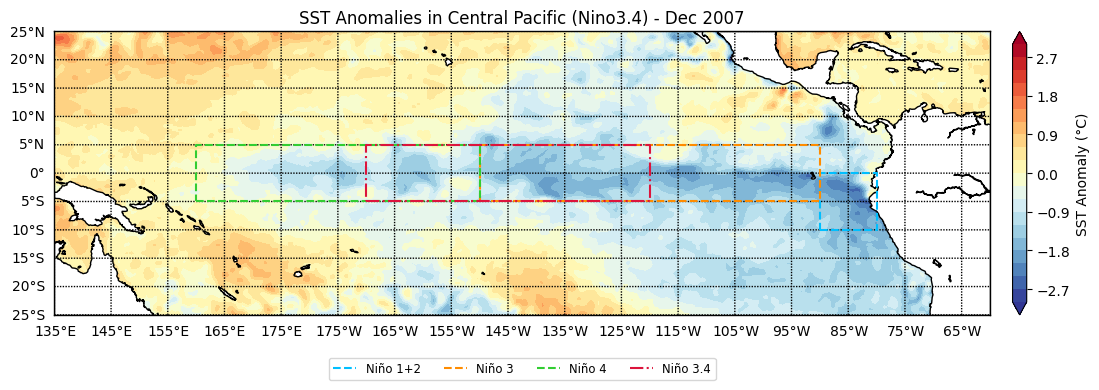

In [11]:
plot_ssta_grid(grid, pd.to_datetime(start), lon0, lon1+360, lat0, lat1)

In [12]:
# Function to get Niño 3.4 SST anomalies from NOAA data
def get_nino34_anomalies(start="1950", end="2025"):
    url = "https://psl.noaa.gov/data/timeseries/month/data/nino34.long.anom.data"
    response = requests.get(url, timeout=30)
    lines = response.text.strip().split('\n')[1:]  # skip header

    data = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) < 13:
            continue
        try:
            year = int(parts[0])
            if year < int(start[:4]) or year > int(end[:4]):
                continue
            for i, val in enumerate(parts[1:13]):
                if '-99.99' in val:
                    break
                ts = pd.Timestamp(year=year, month=i + 1, day=15)
                data.append((ts, float(val)))
        except ValueError:
            continue

    return pd.DataFrame(data, columns=["date", "ssta"]).set_index("date")


In [13]:
ssta = get_nino34_anomalies("1950", "2025")
print(ssta.head())

            ssta
date            
1950-01-15 -1.05
1950-02-15 -1.50
1950-03-15 -1.07
1950-04-15 -0.91
1950-05-15 -1.30


In [ ]:
'''
# Fetch ODB MHW API data year by year for the specified region
def fetch_yearly_data(lon0, lat0, lon1, lat1, start_year, end_year):
    all_data = []
    for year in range(start_year, end_year + 1):
        start = f"{year}-01-01"
        end = f"{year}-12-31"
        print(f"Fetching data for {start} to {end}...")
        yearly_data = fetch_mhw_data(lon0, lat0, lon1, lat1, start, end)
        if yearly_data is not None:
            all_data.append(yearly_data)
    if all_data:
        return pd.concat(all_data, ignore_index=True)
    else:
        return None
'''        

In [ ]:
'''
start_year, end_year = 1982, 2024  # Iterate year range to get MHW data
ylon0, ylat0, ylon1, ylat1 = -170, -5, -120, 5  # Niño 3.4 region
ydata = fetch_yearly_data(ylon0, ylat0, ylon1, ylat1, start_year, end_year)
ydata.to_csv("../data/nino34_mhw_1982-2024.csv", index=False) # This file may excceed 300MB, just too large to store in GitHub 
'''

In [ ]:
# print(ydata.head())

       lon    lat        date  level        sst  sst_anomaly
0 -169.875 -4.875  1982-01-01      0  28.876776       0.0775
1 -169.625 -4.875  1982-01-01      0  28.823547       0.0411
2 -169.375 -4.875  1982-01-01      0  28.722580      -0.0456
3 -169.125 -4.875  1982-01-01      0  28.680967      -0.0614
4 -168.875 -4.875  1982-01-01      0  28.675159      -0.0333


In [15]:
'''
nino_mean = ydata.groupby("date")["sst_anomaly"].mean()
nino_mean.index = pd.to_datetime(nino_mean.index)
print(nino_mean.head())
print(len(nino_mean))
nino_mean.to_csv("../data/examples/nino34_mean_1982-2024.csv", index=True)

sst_mean = ydata.groupby("date")["sst"].mean()
sst_mean.index = pd.to_datetime(sst_mean.index)
print(sst_mean.head())
print(len(sst_mean))
sst_mean.to_csv("../data/examples/nino34_sst_1982-2024.csv", index=True)
'''
nino_mean  = pd.read_csv("./data/examples/nino34_mean_1982-2024.csv", index_col=0, parse_dates=True)
print(nino_mean.head())

            sst_anomaly
date                   
1982-01-01     0.181876
1982-02-01    -0.139610
1982-03-01    -0.026869
1982-04-01     0.198018
1982-05-01     0.650803


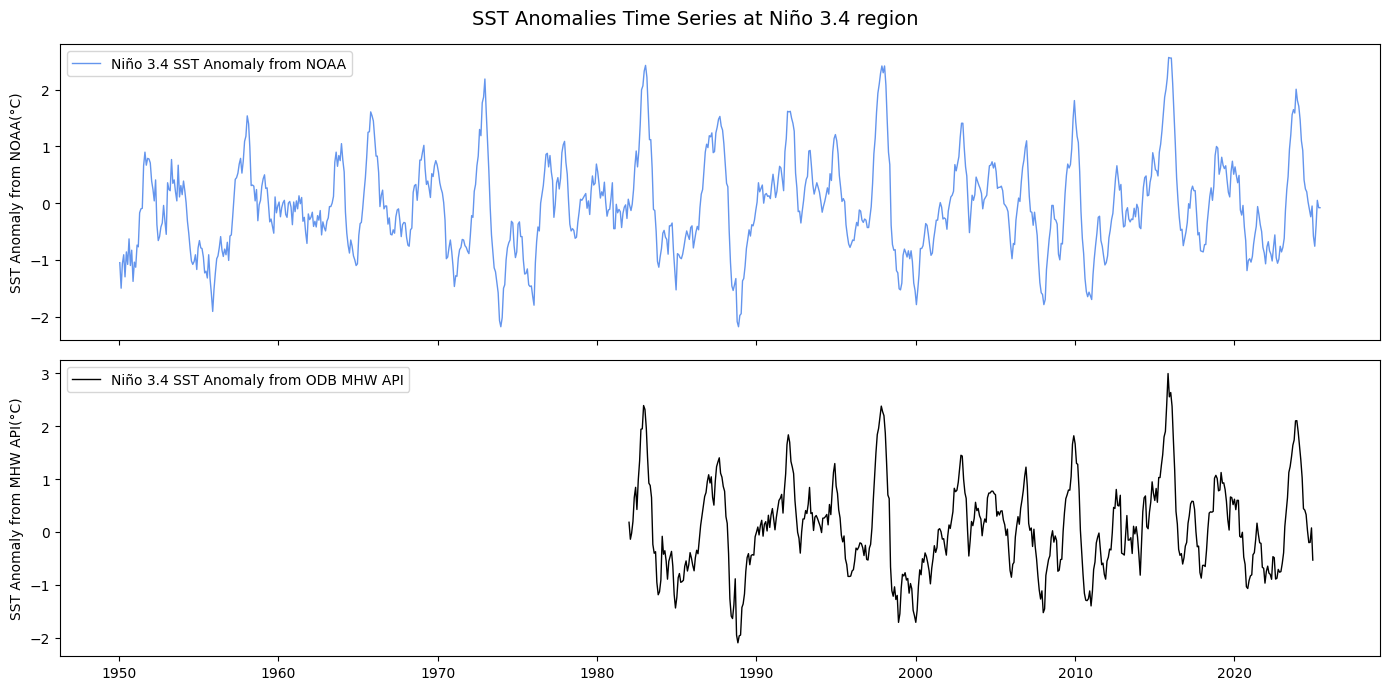

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(14, 7), sharex=True)

# Plot 1: Niño 3.4 SST anomaly
axes[0].plot(ssta.index, ssta, color='cornflowerblue', lw=1)
axes[0].set_ylabel("SST Anomaly from NOAA(°C)")
axes[0].legend(["Niño 3.4 SST Anomaly from NOAA"], loc='upper left')

# Plot 2: Data from ODB MHW API
axes[1].plot(nino_mean.index, nino_mean, color='black', lw=1)
axes[1].set_ylabel("SST Anomaly from MHW API(°C)")
axes[1].legend(["Niño 3.4 SST Anomaly from ODB MHW API"], loc='upper left')

plt.suptitle("SST Anomalies Time Series at Niño 3.4 region", fontsize=14)
fig.tight_layout()


In [18]:
# Refer to https://www.nature.com/articles/s41598-018-38034-z
# Global Disease Outbreaks Associated with the 2015–2016 El Niño Event
# To digitize the Fig.4g and get data: https://github.com/cywhale/marineheatwave/blob/main/API/dev/examples/digitize_plot01.py
# Load the Tanzania cholera data
cholera_df = pd.read_csv('./data/examples/tanzania_cholera_detrended.csv')
print(cholera_df) #It's yearly data!

    year  detrended_cholera_cases
0   2000             -2111.111111
1   2001             -5068.376068
2   2002              4801.975802
3   2003             -5337.218337
4   2004              3572.982573
5   2005             -3071.262071
6   2006              7451.992452
7   2007             -4069.819070
8   2008             -2764.013764
9   2009              1767.898768
10  2010             -1035.742036
11  2011             -4185.037185
12  2012             -4722.721723
13  2013             -4607.503608
14  2014             -4722.721723
15  2015              5838.938839
16  2016              5915.750916
17  2017               116.439116


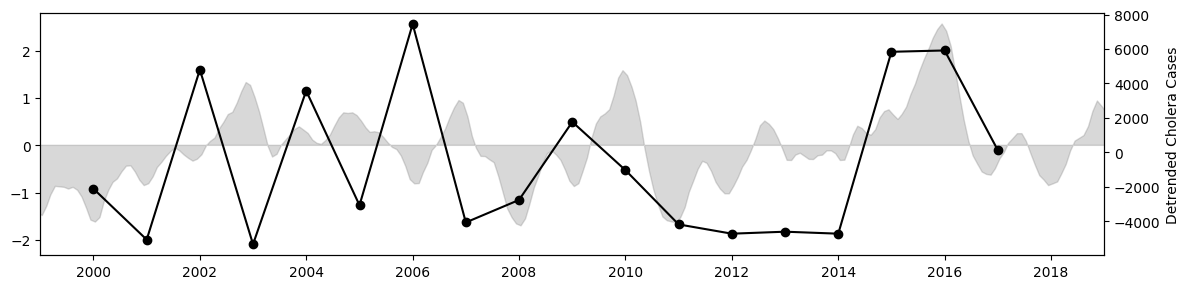

In [19]:
oni = ssta['ssta'].rolling(window=3, center=True).mean()

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 3))

# 1. Gray shaded full ONI curve
ax1.fill_between(oni.index, oni, 0, color='gray', alpha=0.3, label='ONI 3mo mean')

# 2. Cholera annual points at mid-year
ax2 = ax1.twinx()
cholera_dates = pd.to_datetime(cholera_df["year"].astype(str)) 
ax2.set_xlim(pd.Timestamp("1999-01-01"), pd.Timestamp("2018-12-31"))
ax2.plot(cholera_dates, cholera_df["detrended_cholera_cases"], 'ko-', label='Cholera Cases')
ax2.set_ylabel("Detrended Cholera Cases")
fig.tight_layout()

In [20]:
# Determine El Niño / La Niña years using ONI following NOAA criteria
# Following https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php
def classify_enso_events(df, min_months=5, threshold=0.5):
    df = df.copy()
    df['oni_3mo'] = df['ssta'].rolling(window=3, center=True).mean()

    def phase_classify(x):
        if x >= threshold:
            return "El Niño"
        elif x <= -threshold:
            return "La Niña"
        else:
            return "Neutral"

    df['phase'] = df['oni_3mo'].apply(phase_classify)

    # Identify runs of El Niño or La Niña
    df['group'] = (df['phase'] != df['phase'].shift()).cumsum()
    grouped = df.groupby('group')

    result = []
    for _, g in grouped:
        phase = g['phase'].iloc[0]
        if phase in ['El Niño', 'La Niña'] and len(g) >= min_months:
            start = g.index[0]
            end = g.index[-1]
            peak_ONI = g['oni_3mo'].max() if phase == 'El Niño' else g['oni_3mo'].min()
            result.append({
                'start': start,
                'end': end,
                'phase': phase,
                'peak_ONI': peak_ONI
            })

    return pd.DataFrame(result)

In [22]:
enso_phase = classify_enso_events(ssta)
print(enso_phase.head())

       start        end    phase  peak_ONI
0 1950-02-15 1951-03-15  La Niña -1.206667
1 1951-08-15 1951-12-15  El Niño  0.786667
2 1954-05-15 1956-12-15  La Niña -1.673333
3 1957-06-15 1958-04-15  El Niño  1.373333
4 1963-07-15 1964-01-15  El Niño  0.880000


In [23]:
def plot_enso_timeseries_bar(ssta: pd.DataFrame,
                             enso_events: pd.DataFrame):
    # import matplotlib.pyplot as plt
    # import matplotlib.dates as mdates
    # 展平 ENSO 事件為每月資料
    enso_long = []
    for _, row in enso_events.iterrows():
        period = pd.date_range(start=row["start"], end=row["end"], freq="MS")
        for date in period:
            enso_long.append({
                "date": date.replace(day=15),
                "phase": row["phase"]
            })
    enso_long = pd.DataFrame(enso_long)
    enso_long.set_index("date", inplace=True)

    # 加入 SSTA 值
    enso_long = enso_long.join(ssta)

    # 建立 bar 資料
    enso_colors = []
    enso_bar_values = []
    for _, row in enso_long.iterrows():
        val = row['ssta']
        if row['phase'] == "El Niño":
            enso_colors.append('#f8766d')
            enso_bar_values.append(val)
        elif row['phase'] == "La Niña":
            enso_colors.append('#619cff')
            enso_bar_values.append(val)  # 負值顯示向下
        else:
            enso_colors.append('lightgray')
            enso_bar_values.append(0)

    # 建立圖表
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True,
                             gridspec_kw={'height_ratios': [1.2, 1]})

    # Plot 1: Niño 3.4 SSTA
    axes[0].plot(ssta.index, ssta['ssta'], color='cornflowerblue', lw=1, label="Niño 3.4 SSTA")
    axes[0].axhline(y=0.5, linestyle="dotted", linewidth=0.5, color="red", label="El Niño")
    axes[0].axhline(y=-0.5, linestyle="dotted", linewidth=0.5, color="blue", label="La Niña")
    axes[0].set_ylabel("SST Anomaly (°C)")
    axes[0].legend(loc='upper left')
    axes[0].axhline(0, color='black', linewidth=0.5)

    # Plot 2: ENSO Events
    axes[1].bar(enso_long.index, enso_bar_values, color=enso_colors, width=20)
    axes[1].axhline(y=1.5, linestyle="--", linewidth=0.5, color="red", label="Strong El Niño")
    axes[1].axhline(y=-1.5, linestyle="--", linewidth=0.5, color="blue", label="Strong La Niña")
    axes[1].set_ylabel("ENSO Phase\n(Bar ~ SSTA)")
    axes[1].set_ylim(-2.5, 2.5)
    axes[1].legend(loc='upper left')

    # X-axis formatting
    axes[-1].xaxis.set_major_locator(mdates.YearLocator(5))
    axes[-1].xaxis.set_minor_locator(mdates.YearLocator(1))
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    axes[-1].grid(True, axis='x', which='major', linestyle='--', alpha=0.3)

    plt.suptitle("ENSO Time Series: Niño 3.4 SSTA and ENSO events", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

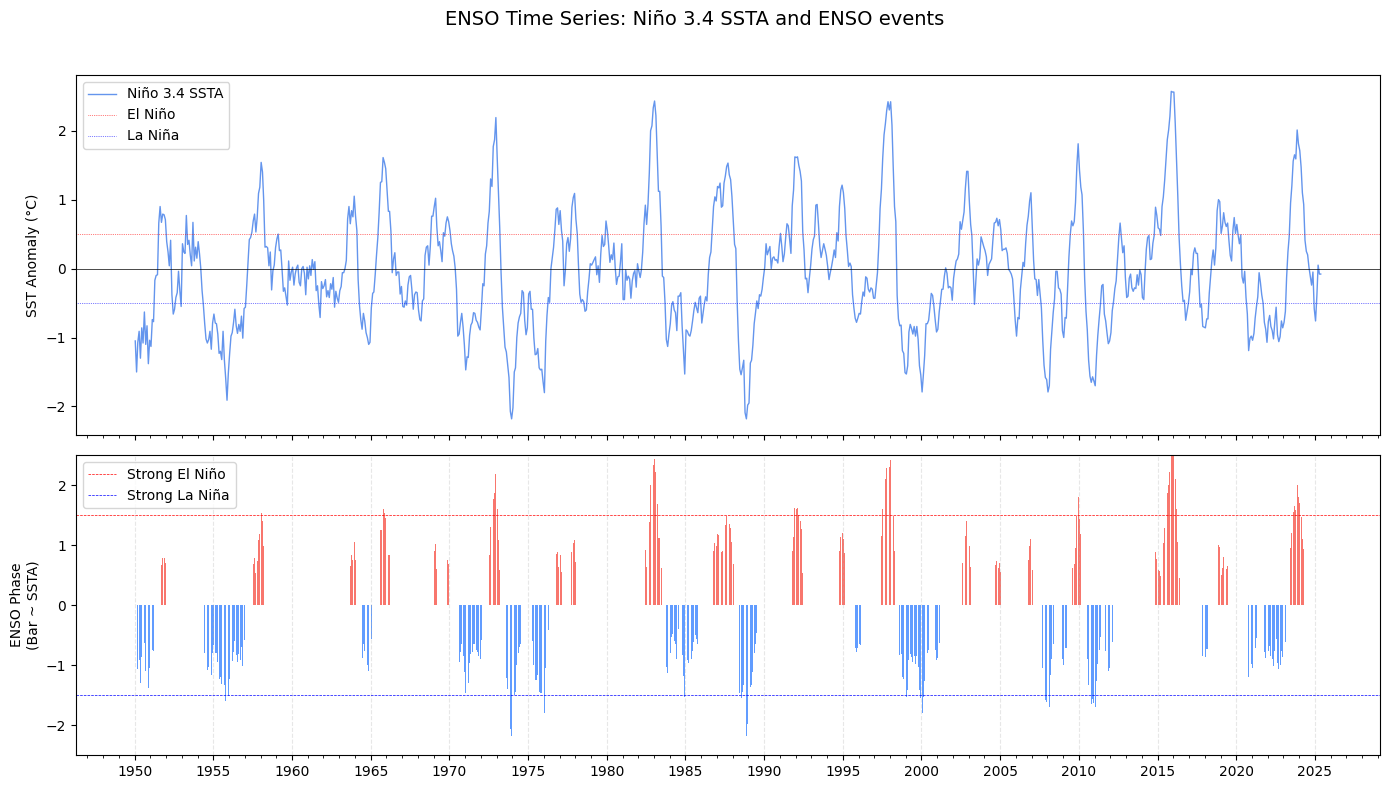

In [24]:
plot_enso_timeseries_bar(ssta, enso_phase)

In [25]:
nino_df = get_nino34_anomalies()
nino_df["oni_3mo"] = nino_df["ssta"].rolling(3, center=True).mean()

events_df = classify_enso_events(nino_df)

# ---------- Create a monthly phase series ----------
phase_series = pd.Series("Neutral", index=nino_df.index)
for _, row in events_df.iterrows():
    phase_series.loc[row["start"]:row["end"]] = row["phase"]

print(phase_series.head())

date
1950-01-15    Neutral
1950-02-15    La Niña
1950-03-15    La Niña
1950-04-15    La Niña
1950-05-15    La Niña
dtype: object


In [26]:
# 1. 原始 Niño 3.4 SST 異常, the same as ssta
nino_df = get_nino34_anomalies()
nino_df["oni_3mo"] = nino_df["ssta"].rolling(3, center=True).mean()

events_df = classify_enso_events(nino_df)

# ---------- Create a monthly phase series ----------
phase_series = pd.Series("Neutral", index=nino_df.index)
for _, row in events_df.iterrows():
    phase_series.loc[row["start"]:row["end"]] = row["phase"]

# ---------- Build annual DJF table (1999-12/2000-02 etc.) ----------
# Trick: how you treat ENSO events (DJF) as this year's phase or next year's phase
rows = []
for yr in range(1999, 2017):  # target cholera years
    months = [pd.Timestamp(yr, 12, 15),  # try range(2000, 2018) and yr-1, yr, totally different results!
              pd.Timestamp(yr+1, 1, 15),
              pd.Timestamp(yr+1, 2, 15)]
    oni_vals = nino_df.loc[months, "oni_3mo"].values
    djf_mean = float(pd.Series(oni_vals).mean())
    phases = phase_series.loc[months].unique()
    # Determine yearly phase: prefer El/La if present
    if "El Niño" in phases:
        y_phase = "El Niño"
    elif "La Niña" in phases:
        y_phase = "La Niña"
    else:
        y_phase = "Neutral"
    rows.append({"year": yr, "oni_djf": djf_mean, "enso_phase": y_phase})

df_djf = pd.DataFrame(rows)
merged_df = cholera_df.merge(df_djf, on="year", how="left")
print(merged_df)

    year  detrended_cholera_cases   oni_djf enso_phase
0   2000             -2111.111111 -0.774444    La Niña
1   2001             -5068.376068 -0.167778    Neutral
2   2002              4801.975802  0.992222    El Niño
3   2003             -5337.218337  0.227778    Neutral
4   2004              3572.982573  0.502222    El Niño
5   2005             -3071.262071 -0.781111    Neutral
6   2006              7451.992452  0.560000    El Niño
7   2007             -4069.819070 -1.637778    La Niña
8   2008             -2764.013764 -0.812222    La Niña
9   2009              1767.898768  1.425556    El Niño
10  2010             -1035.742036 -1.492222    La Niña
11  2011             -4185.037185 -0.853333    La Niña
12  2012             -4722.721723 -0.236667    Neutral
13  2013             -4607.503608 -0.270000    Neutral
14  2014             -4722.721723  0.646667    El Niño
15  2015              5838.938839  2.354444    El Niño
16  2016              5915.750916 -0.308889    Neutral
17  2017  

enso_phase
El Niño    6
La Niña    5
Neutral    6
dtype: int64


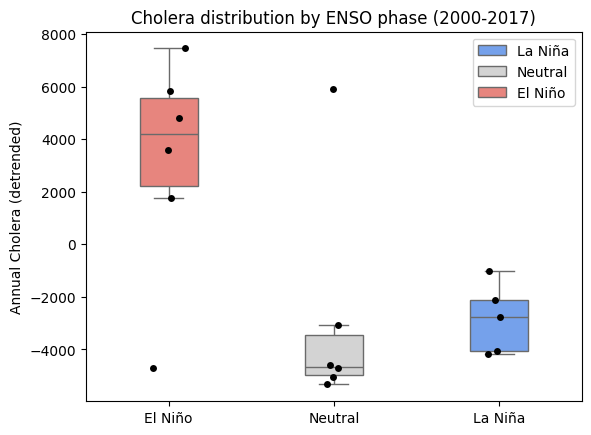

In [27]:
# import seaborn as sns, matplotlib.pyplot as plt
# 分組樣本數
print(merged_df.groupby('enso_phase').size())
sns.axes_style()
sns.boxplot(data=merged_df, x='enso_phase', y='detrended_cholera_cases',
            order=['El Niño','Neutral','La Niña'],
            showfliers=False, width=0.35, hue='enso_phase', 
            palette={'El Niño':'#f8766d','La Niña':'#619cff','Neutral':'lightgray'})
sns.stripplot(data=merged_df, x='enso_phase', y='detrended_cholera_cases',
              order=['El Niño','Neutral','La Niña'],
              color='black', jitter=0.1)
plt.ylabel('Annual Cholera (detrended)'); plt.xlabel('')
plt.title('Cholera distribution by ENSO phase (2000-2017)')
plt.show()


In [28]:
def plot_cholera_vs_enso(cholera_df, nino_df, events_df):
    # import matplotlib.pyplot as plt
    # Prepare ONI 3-month moving average (masked/clean)
    oni = nino_df['ssta'].rolling(window=3, center=True).mean().dropna().astype(float)

    # Flatten ENSO events into monthly records for bar heights
    enso_long = []
    for _, row in events_df.iterrows():
        period = pd.date_range(start=row["start"], end=row["end"], freq="MS")
        for date in period:
            enso_long.append({"date": date.replace(day=15), "phase": row["phase"]})
    enso_long = pd.DataFrame(enso_long).set_index("date")
    enso_long = enso_long.join(nino_df["ssta"], how="left")

    # Determine colors and bar heights
    enso_colors = []
    enso_bar_values = []
    for _, row in enso_long.iterrows():
        val = row['ssta']
        if row['phase'] == "El Niño":
            enso_colors.append('#f8766d')
            enso_bar_values.append(val)
        elif row['phase'] == "La Niña":
            enso_colors.append('#619cff')
            enso_bar_values.append(val)
        else:
            # neutral — optional: lightgray or zero height
            enso_colors.append('lightgray')
            enso_bar_values.append(0)

    # Plotting
    fig, ax1 = plt.subplots(figsize=(12, 3))

    # 1. Gray shaded full ONI curve
    ax1.fill_between(oni.index, oni, 0, color='gray', alpha=0.3, label='ONI 3mo mean')

    # 2. Red/blue bars for ENSO months
    ax1.bar(enso_long.index, enso_bar_values, width=20, color=enso_colors, alpha=0.7, label='ENSO anomaly')

    # 3. Trick: Cholera annual points at end of the year (Oct, before DJF events)
    ax2 = ax1.twinx()
    cholera_dates = pd.to_datetime(cholera_df["year"].astype(str)) + pd.DateOffset(months=10, days=15)
    ax2.plot(cholera_dates, cholera_df["detrended_cholera_cases"], 'ko-', label='Cholera Cases')
    ax2.set_ylabel("Detrended Cholera Cases")

    # 4. Optional: DJF ONI dashed line
    if "oni_djf" in cholera_df.columns:
        ax2.plot(cholera_dates, cholera_df["oni_djf"] * 1000, 'k--', alpha=0.5, label="DJF ONI ×1000")

    # Labels, limits, legends
    ax1.set_ylabel("Niño 3.4 SSTA (°C)")
    ax1.set_xlim(pd.Timestamp("1999-01-01"), pd.Timestamp("2018-12-31"))
    ax1.set_title("Tanzania Cholera vs Monthly ONI & ENSO Anomalies (bars)")

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.tight_layout()
    plt.show()


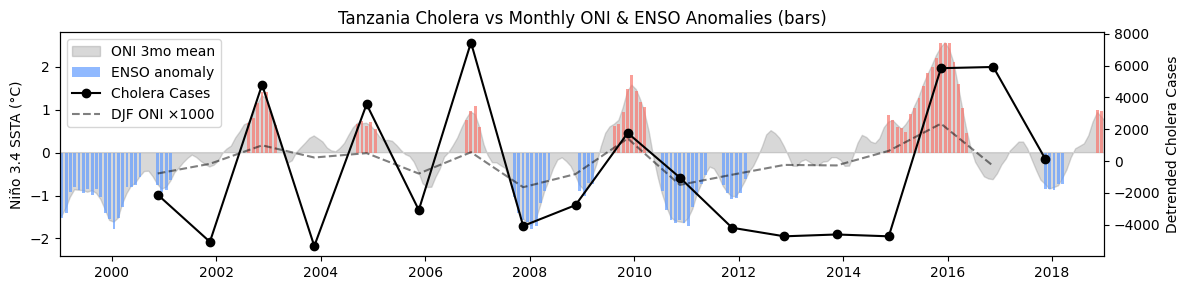

In [29]:
plot_cholera_vs_enso(merged_df, nino_df, events_df)

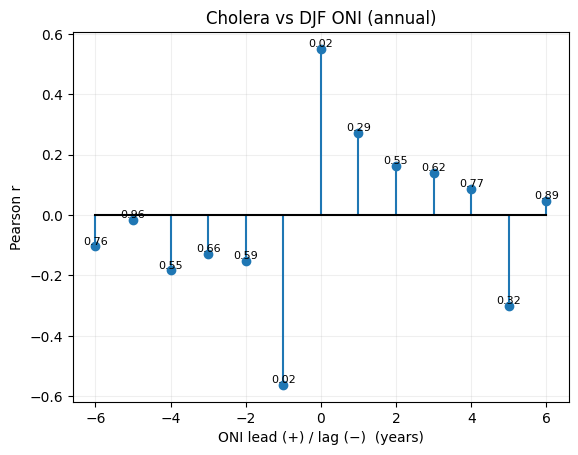

In [30]:
# Correlation analysis between cholera cases and ONI
# from scipy.stats import pearsonr

chol = merged_df.set_index('year')['detrended_cholera_cases']
oni  = merged_df.set_index('year')['oni_djf']

lags = range(-6, 7)          # ONI lead (+) / lag (−)
# corr = [merged_df['detrended_cholera_cases'].corr(merged_df['oni_djf'].shift(l)) for l in lags]
corr, pval = [], []
for l in lags:
    pair = pd.concat([chol, oni.shift(l)], axis=1).dropna()
    r, p = pearsonr(pair.iloc[:,0], pair.iloc[:,1])
    corr.append(r); pval.append(p)

plt.stem(lags, corr, basefmt='k-')
for x,y,p in zip(lags, corr, pval):
    plt.text(x, y, f'{p:.2f}', ha='center', va='bottom', fontsize=8)
plt.xlabel('ONI lead (+) / lag (−)  (years)')
plt.ylabel('Pearson r')
plt.title('Cholera vs DJF ONI (annual)')
plt.grid(alpha=.2)
plt.show()


In [31]:
# 1. Simulate trend + seasonality + noise
np.random.seed(2024)
n = 100
t = np.arange(1, n+1)
time_index = pd.date_range("2000-01-01", periods=n, freq="ME")

mu = -5 + 0.1 * t                       # 線性趨勢
ss = np.sin(2 * np.pi * t / 12)         # 每 12 期的季節性
e = 0.5 * np.random.randn(n)            # 隨機噪音
y = mu + ss + e

df = pd.DataFrame({"y": y, "signal": mu + ss}, index=time_index)

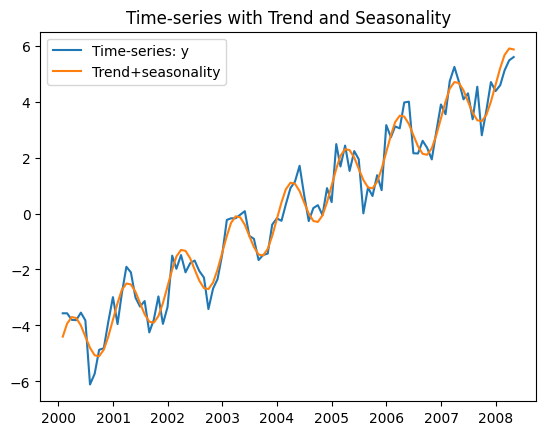

In [32]:
plt.figure()
plt.plot(df.index, df["y"], label="Time-series: y")
plt.plot(df.index, df["signal"], label="Trend+seasonality")
plt.legend()
plt.title("Time-series with Trend and Seasonality");

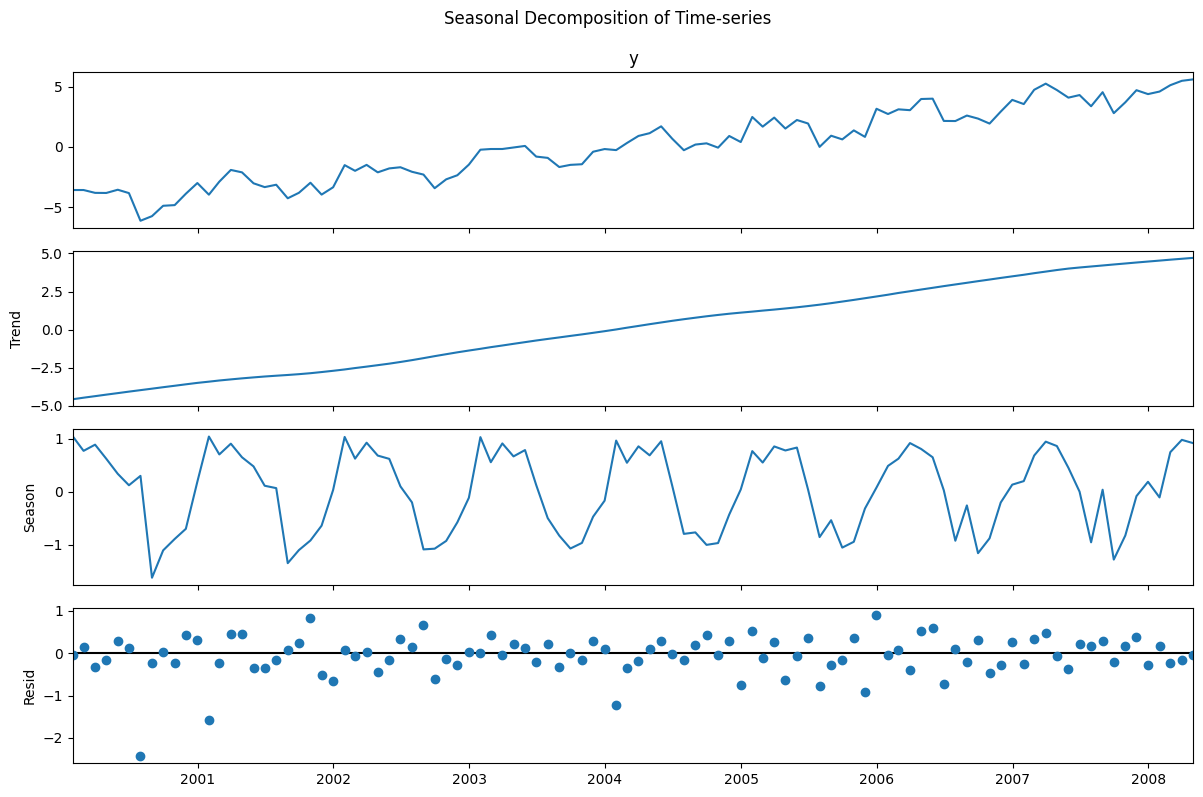

In [34]:
# from statsmodels.tsa.seasonal import STL
stl = STL(df["y"],
          period=12,
          robust=True).fit()
fig = stl.plot()
fig.set_size_inches(12, 8)
fig.suptitle(f"Seasonal Decomposition of Time-series", y=0.99)
plt.tight_layout()
   

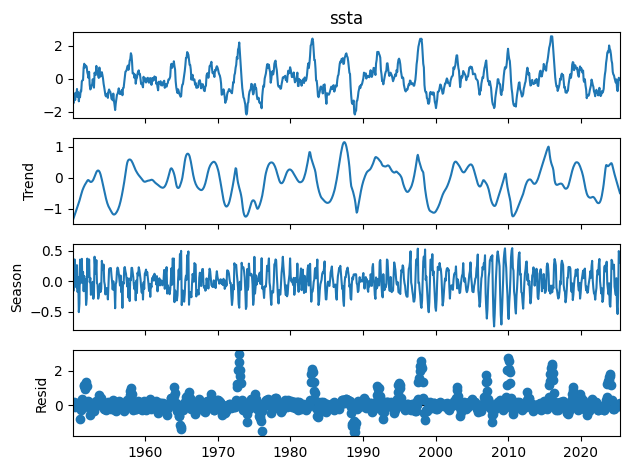

In [35]:
#sst_mean  = pd.read_csv("./data/examples/nino34_sst_1982-2024.csv", index_col=0, parse_dates=True)
stla = STL(ssta["ssta"], period=12, robust=True).fit()
stla.plot();

In [36]:
def plot_eemd_decomposition_series(series: pd.Series, label="", max_imfs=None):
    # from PyEMD import EEMD
    # import matplotlib.pyplot as plt
    # import matplotlib.dates as mdates
    # import numpy as np

    # Interpolate any gaps
    series = series.interpolate("time").dropna()
    x = series.values
    t = np.arange(len(x))

    eemd = EEMD(trials=100, noise_width=0.2)
    eemd.eemd(x, t)
    IMFs, residual = eemd.get_imfs_and_residue()

    n_imfs = IMFs.shape[0] if max_imfs is None else min(IMFs.shape[0], max_imfs)
    fig, axes = plt.subplots(n_imfs + 1, 1, figsize=(12, 2.2*(n_imfs+1)), sharex=True)

    for i in range(n_imfs):
        axes[i].plot(series.index, IMFs[i], label=f"IMF {i+1}")
        axes[i].legend(loc="upper right")
        axes[i].grid(alpha=0.3)

    axes[-1].plot(series.index, residual, 'k', label="Residual (trend)")
    axes[-1].legend(loc="upper right")
    axes[-1].grid(alpha=0.3)

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
    # ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1, 7]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    fig.suptitle(f"EEMD decomposition of {label} series", fontsize=14)
    fig.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

    return series, IMFs, residual


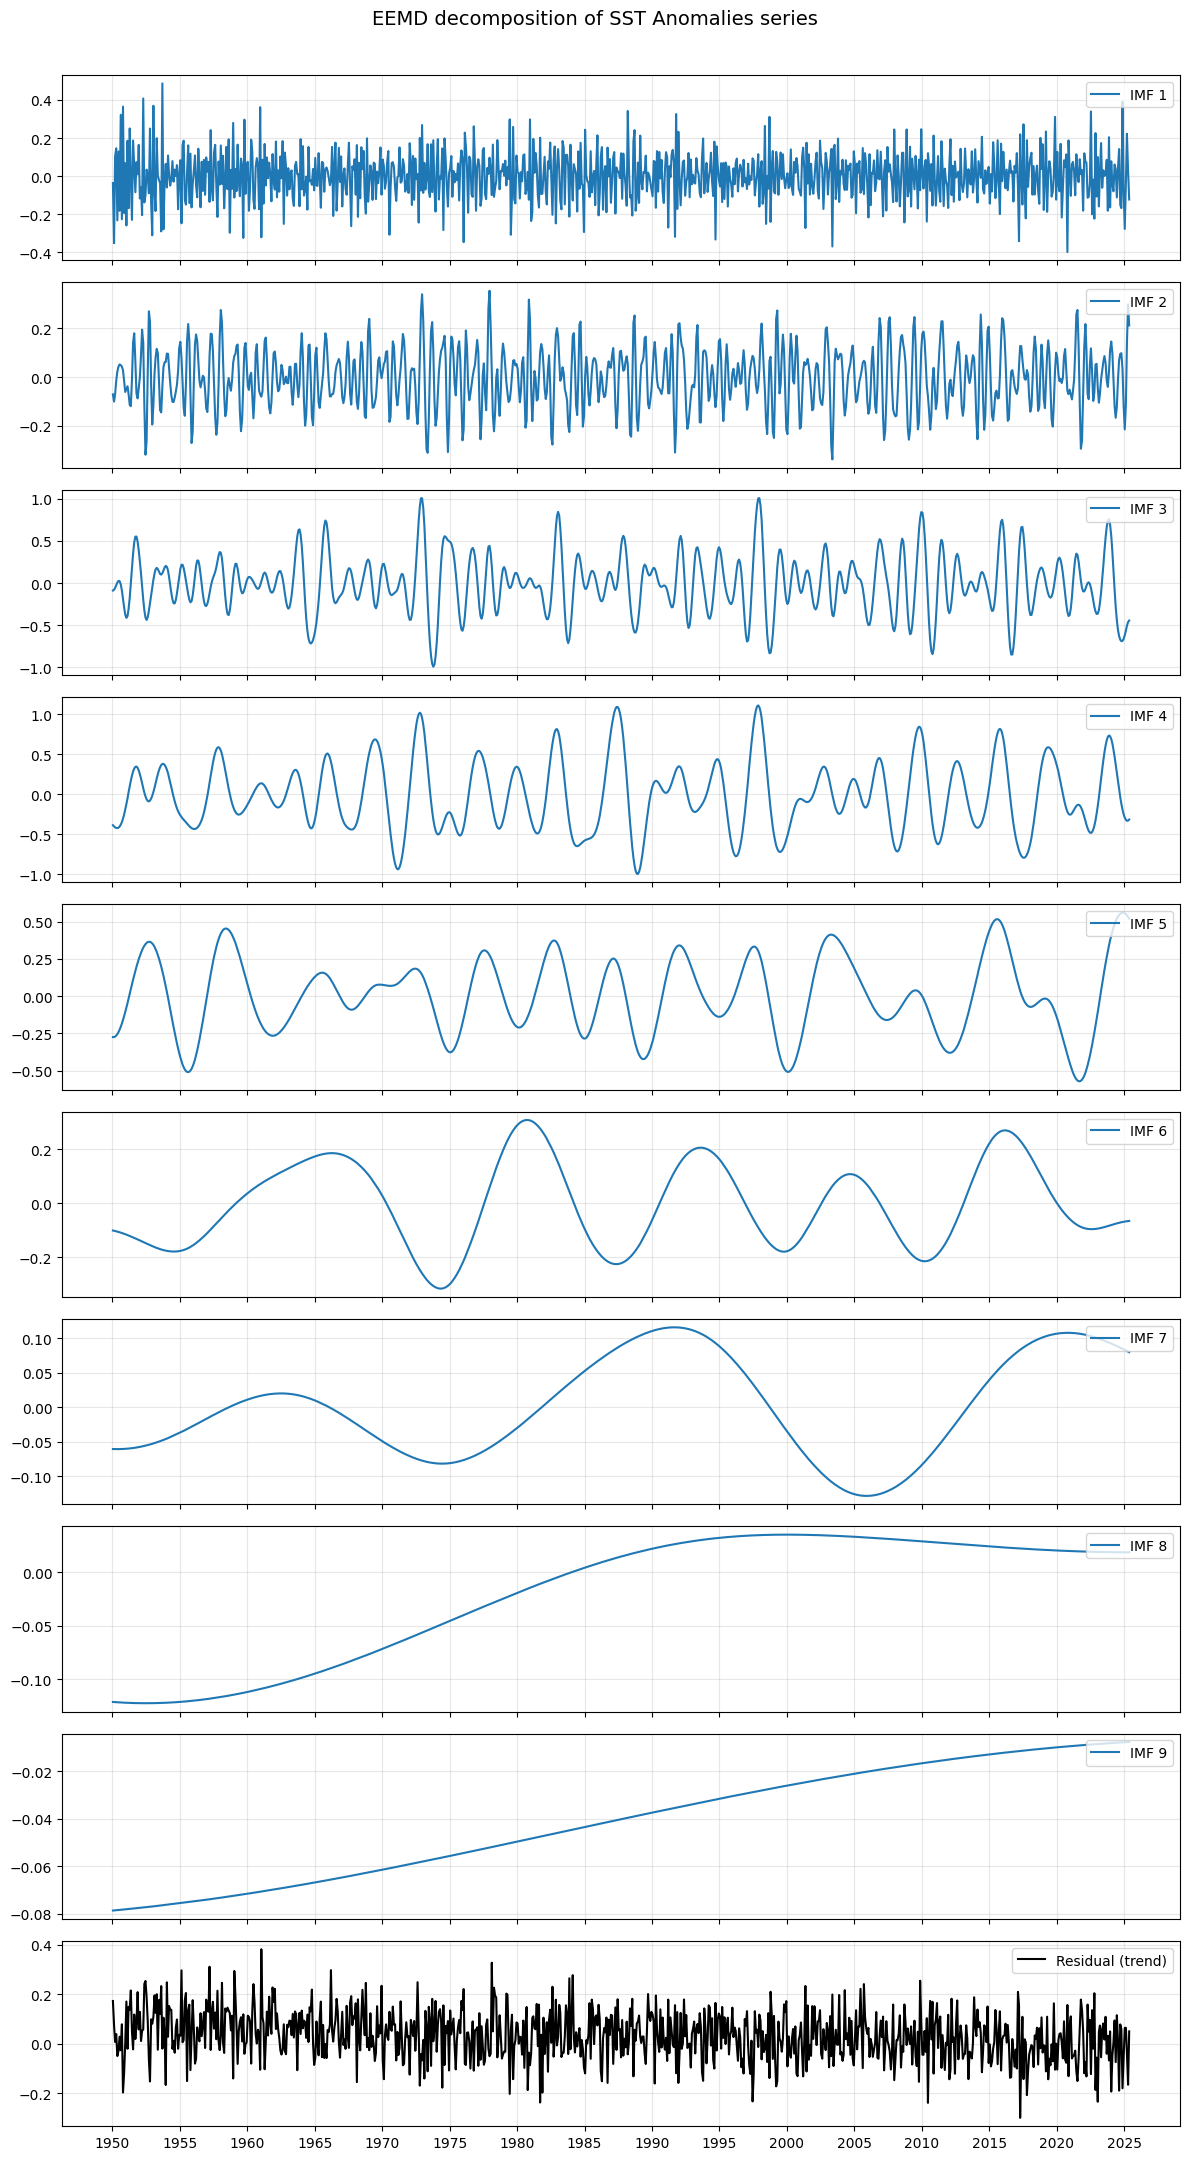

In [37]:
ssta_series, IMF_ssta, resid_ssta = plot_eemd_decomposition_series(ssta['ssta'], label="SST Anomalies")

In [38]:
def imf_fft_peak_periods(IMFs: np.ndarray,
                         dt: float = 1.0,
                         units: Literal["days", "months"] = "days",
                         to_months: bool = False) -> pd.DataFrame:
    """
    Compute dominant periods of IMFs using FFT.

    Args:
        IMFs: array of shape (n_imfs, n_samples)
        dt: sampling interval (1.0 = daily, 1/30 = monthly if unit is 'days')
        units: 'days' or 'months' — determines output unit

    Returns:
        DataFrame with:
            - IMF: 1-based index
            - peak_freq: cycles per unit (e.g., per day or month)
            - peak_period: inverse of peak frequency, in chosen unit
    """
    import numpy as np
    import pandas as pd

    n_imfs, N = IMFs.shape
    freqs = np.fft.rfftfreq(N, d=dt)
    result = []

    for i, imf in enumerate(IMFs, start=1):
        P = np.abs(np.fft.rfft(imf))**2
        idx = np.argmax(P[1:]) + 1  # skip DC
        f = freqs[idx]
        period = 1/f if f > 0 else np.inf
        pmonth = period/30 if to_months else np.nan
        result.append({
            "IMF": i,
            "peak_freq": f,
            f"peak_period_{units}": period
        })
        if to_months:
            result[-1]["peak_period_months"] = pmonth

    return pd.DataFrame(result)


In [39]:
fft_stats = imf_fft_peak_periods(IMF_ssta, dt=1.0, units="months")
print(fft_stats)

   IMF  peak_freq  peak_period_months
0    1   0.499448            2.002212
1    2   0.149171            6.703704
2    3   0.056354           17.745098
3    4   0.023204           43.095238
4    5   0.013260           75.416667
5    6   0.006630          150.833333
6    7   0.002210          452.500000
7    8   0.001105          905.000000
8    9   0.001105          905.000000


In [40]:
# from scipy.signal import periodogram
# Simulated IMF data (for demo, replace with your real IMF matrix)
# np.random.seed(0)
# t = np.arange(0, 3650)  # 10 years of daily data
# IMFs = [np.sin(2 * np.pi * t / p) + 0.1 * np.random.randn(len(t)) for p in [90, 120, 180, 240, 365, 512, 730, 1000]]

# Plot IMF FFTs
def plot_imf_periodograms(IMFs: np.ndarray, to_months: bool = False):
    n = len(IMFs)
    ncols = 2
    nrows = (n + 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 2.5 * nrows))
    axes = axes.ravel()

    for i, imf in enumerate(IMFs):
        f, Pxx = periodogram(imf, fs=1.0)  # fs=1 sample/day
        freq_monthly = f * (30 if to_months else 1)  # cycles/month
        ax = axes[i]
        ax.plot(freq_monthly, Pxx, color='blue', lw=1)
        ax.set_xlim(0, 0.5)
        ax.set_xlabel("Frequency (cycle/month)")
        ax.set_ylabel("Variance Density\n($m^2$/month)")

        # Estimate peak period
        peak_idx = np.argmax(Pxx[1:]) + 1  # skip DC
        peak_freq = freq_monthly[peak_idx]
        peak_period = 1 / peak_freq if peak_freq > 0 else np.nan

        if peak_freq > 0 and peak_freq < 0.5:
            ax.text(peak_freq + 0.025, Pxx.max()*0.8,  # x and y placement
                    f"Peak frequency:\n{peak_freq:.4f}",
                    fontsize=10, bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray'),
                    transform=ax.transData)
        ax.set_title(f"IMF{i+1}\nPeak Period: {peak_period:.1f} months", fontsize=10)
        ax.grid(True, alpha=0.3)

    for i in range(len(IMFs), len(axes)):
        axes[i].axis("off")

    plt.tight_layout()

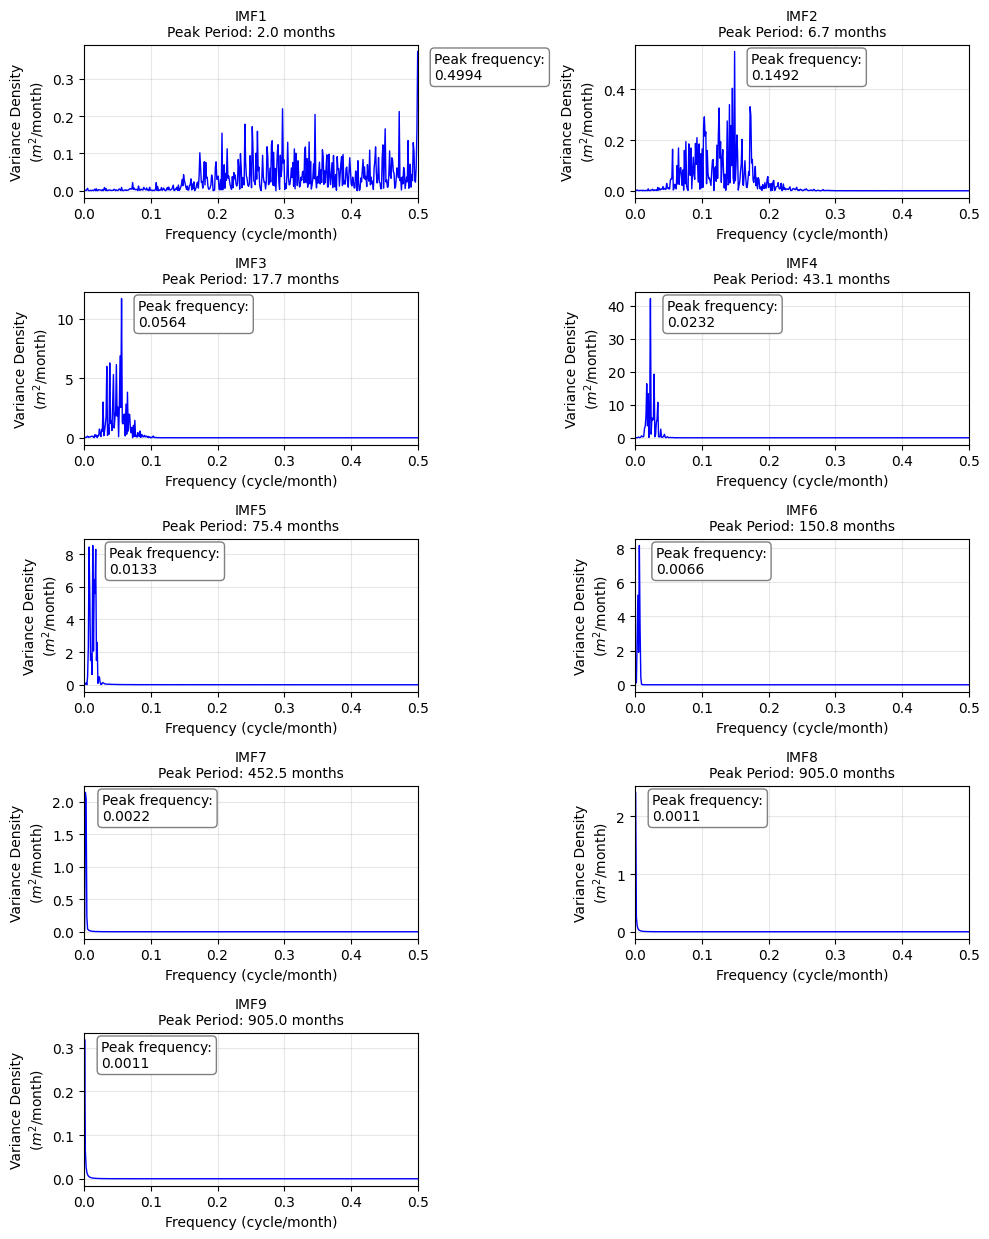

In [41]:
plot_imf_periodograms(IMF_ssta)

In [42]:
def extract_long_term_trend_from_eemd(imfs: np.ndarray,
                                      resid: np.ndarray,
                                      fft_stats: pd.DataFrame,
                                      add_resid: bool = True,
                                      period_fraction: float = 1/3,
                                      period_var: str = 'peak_period_months') -> tuple[list, np.ndarray]:
    """
    Extract long-term component from EEMD results by selecting IMFs whose
    peak period exceeds a fraction of the total signal length.

    Parameters
    ----------
    imfs : np.ndarray
        2D array of IMF components (n_imf, n_time).
    resid : np.ndarray
        Residual component (same length as IMF time series).
    fft_stats : pd.DataFrame
        Output from `imf_fft_peak_periods()` with 'IMF' and 'peak_period_months'.
    add_resid : bool, default=True
        Whether to include residual in final sum.
    period_fraction : float, default=1/3
        Threshold as a fraction of time length to define "long-term".

    Returns
    -------
    long_imf_indices : list
        List of IMF indices (1-based) that are considered long-term.
    long_component : np.ndarray
        1D array of the summed long-term component.
    """
    n = imfs.shape[1]
    threshold = n * period_fraction

    long_mask = fft_stats[period_var] > threshold
    long_imf_indices = fft_stats.loc[long_mask, "IMF"].values.tolist()  # 1-based index

    # Convert to 0-based index for slicing imfs
    long_imfs_array = imfs[[i - 1 for i in long_imf_indices]]

    long_component = long_imfs_array.sum(axis=0)
    if add_resid and resid is not None:
        long_component += resid

    return long_imf_indices, long_component


In [43]:
long_indices, long_component = extract_long_term_trend_from_eemd(
    imfs=IMF_ssta,
    resid=resid_ssta,
    fft_stats=fft_stats,
    add_resid=True,
    period_fraction=1/2
)

print("Long-term IMFs (1-based indices):", long_indices)

Long-term IMFs (1-based indices): [8, 9]


In [44]:
# from statsmodels.nonparametric.smoothers_lowess import lowess
# Apply LOWESS smoothing to get final trend
smooth = lowess(long_component, np.arange(IMF_ssta.shape[1]), frac=0.1, return_sorted=False)

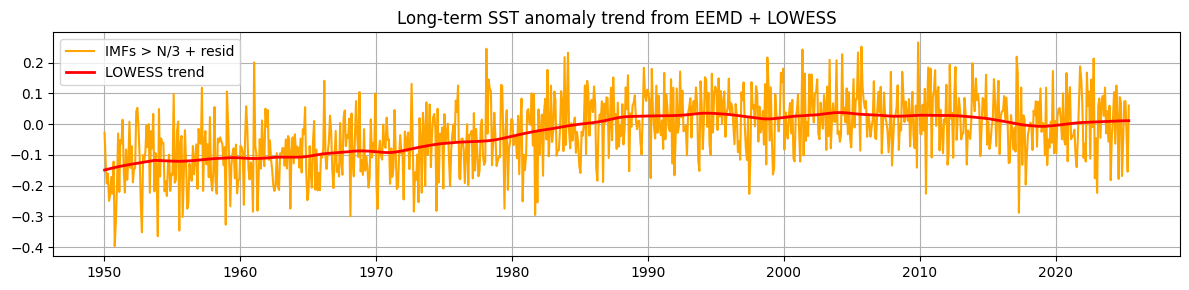

In [45]:
# Plot trend
plt.figure(figsize=(12, 3))
# plt.plot(ssta.index, ssta, label="Original SST anomaly", alpha=0.4)
plt.plot(ssta.index, long_component, label="IMFs > N/3 + resid", color="orange")
plt.plot(ssta.index, smooth, label="LOWESS trend", color="red", linewidth=2)
plt.title("Long-term SST anomaly trend from EEMD + LOWESS")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [46]:
# Testing EEMD by simulating a time series
# 1. Simulate trend + seasonality + noise
np.random.seed(41)
n = 600
t = np.arange(n)
time_index = pd.date_range("1970-01-01", periods=n, freq="ME")
random_ph1 = np.random.uniform(0, np.pi)
random_ph2 = np.random.uniform(0, np.pi)

mu = -2 + 0.001 * t                       # 線性趨勢 -2 + 600 * 0.001 = -1.4
ss = 0.8 * np.sin(2 * np.pi * t / 12)     # 每 12 期的季節性
mm = 0.23 * np.cos(2 * np.pi * t / 43 + random_ph1)    # mid-term seasonality
ll = 0.15 * np.sin(2 * np.pi * t / 101 + random_ph2)   # long-term seasonality
e = 0.5 * np.random.randn(n)            # 隨機噪音
y = mu + ss + mm + ll + e

df = pd.DataFrame({"y": y, "signal": mu + ss + mm + ll}, index=time_index)

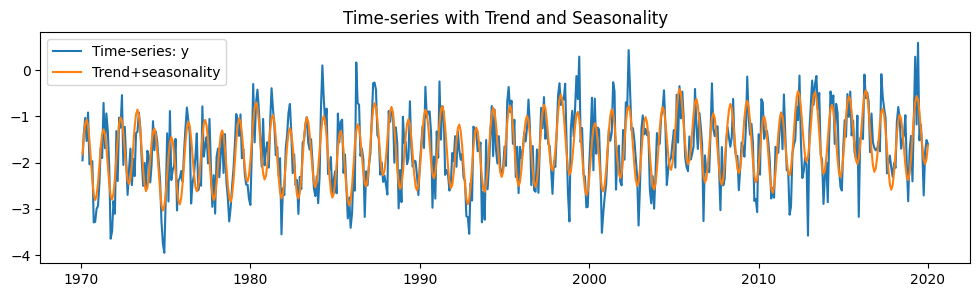

In [47]:
plt.figure(figsize=(12, 3))
plt.plot(df.index, df["y"], label="Time-series: y")
plt.plot(df.index, df["signal"], label="Trend+seasonality")
plt.legend()
plt.title("Time-series with Trend and Seasonality");

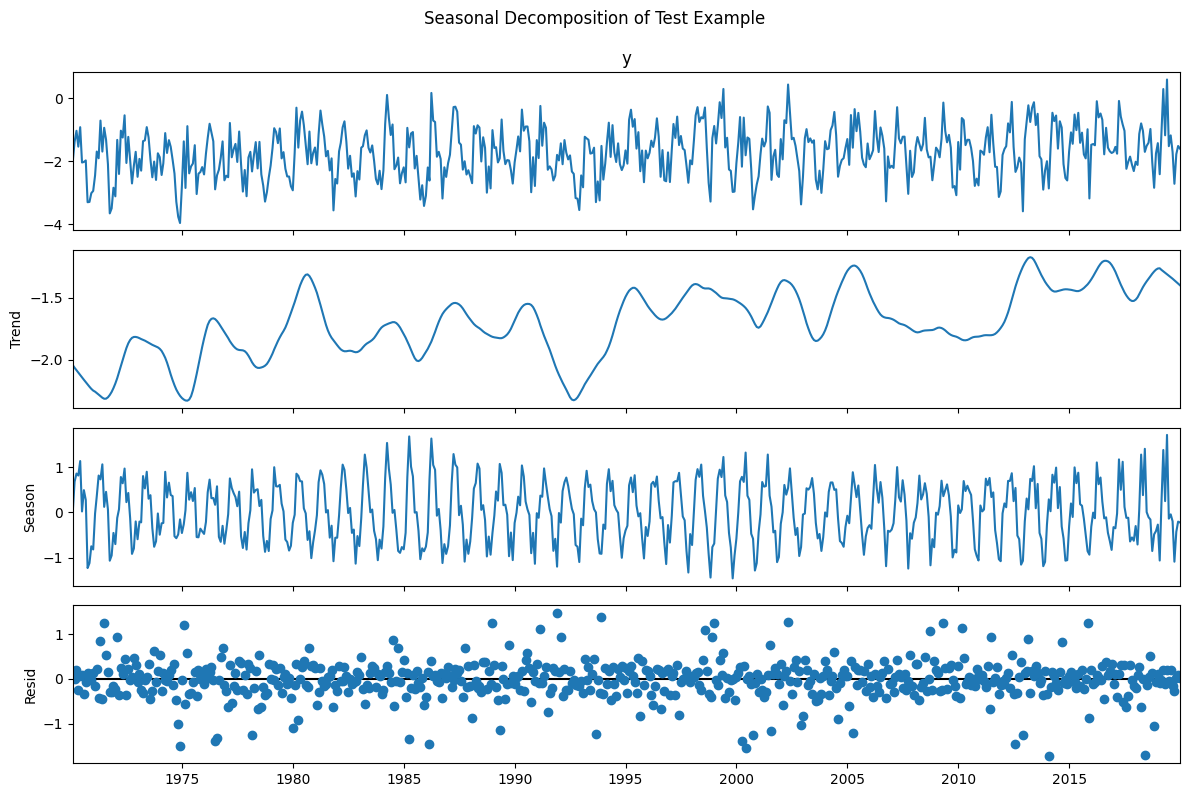

In [48]:
stl = STL(df["y"],
          period=12,
          robust=True).fit()
fig = stl.plot()
fig.set_size_inches(12, 8)
fig.suptitle(f"Seasonal Decomposition of Test Example", y=0.99)
plt.tight_layout()

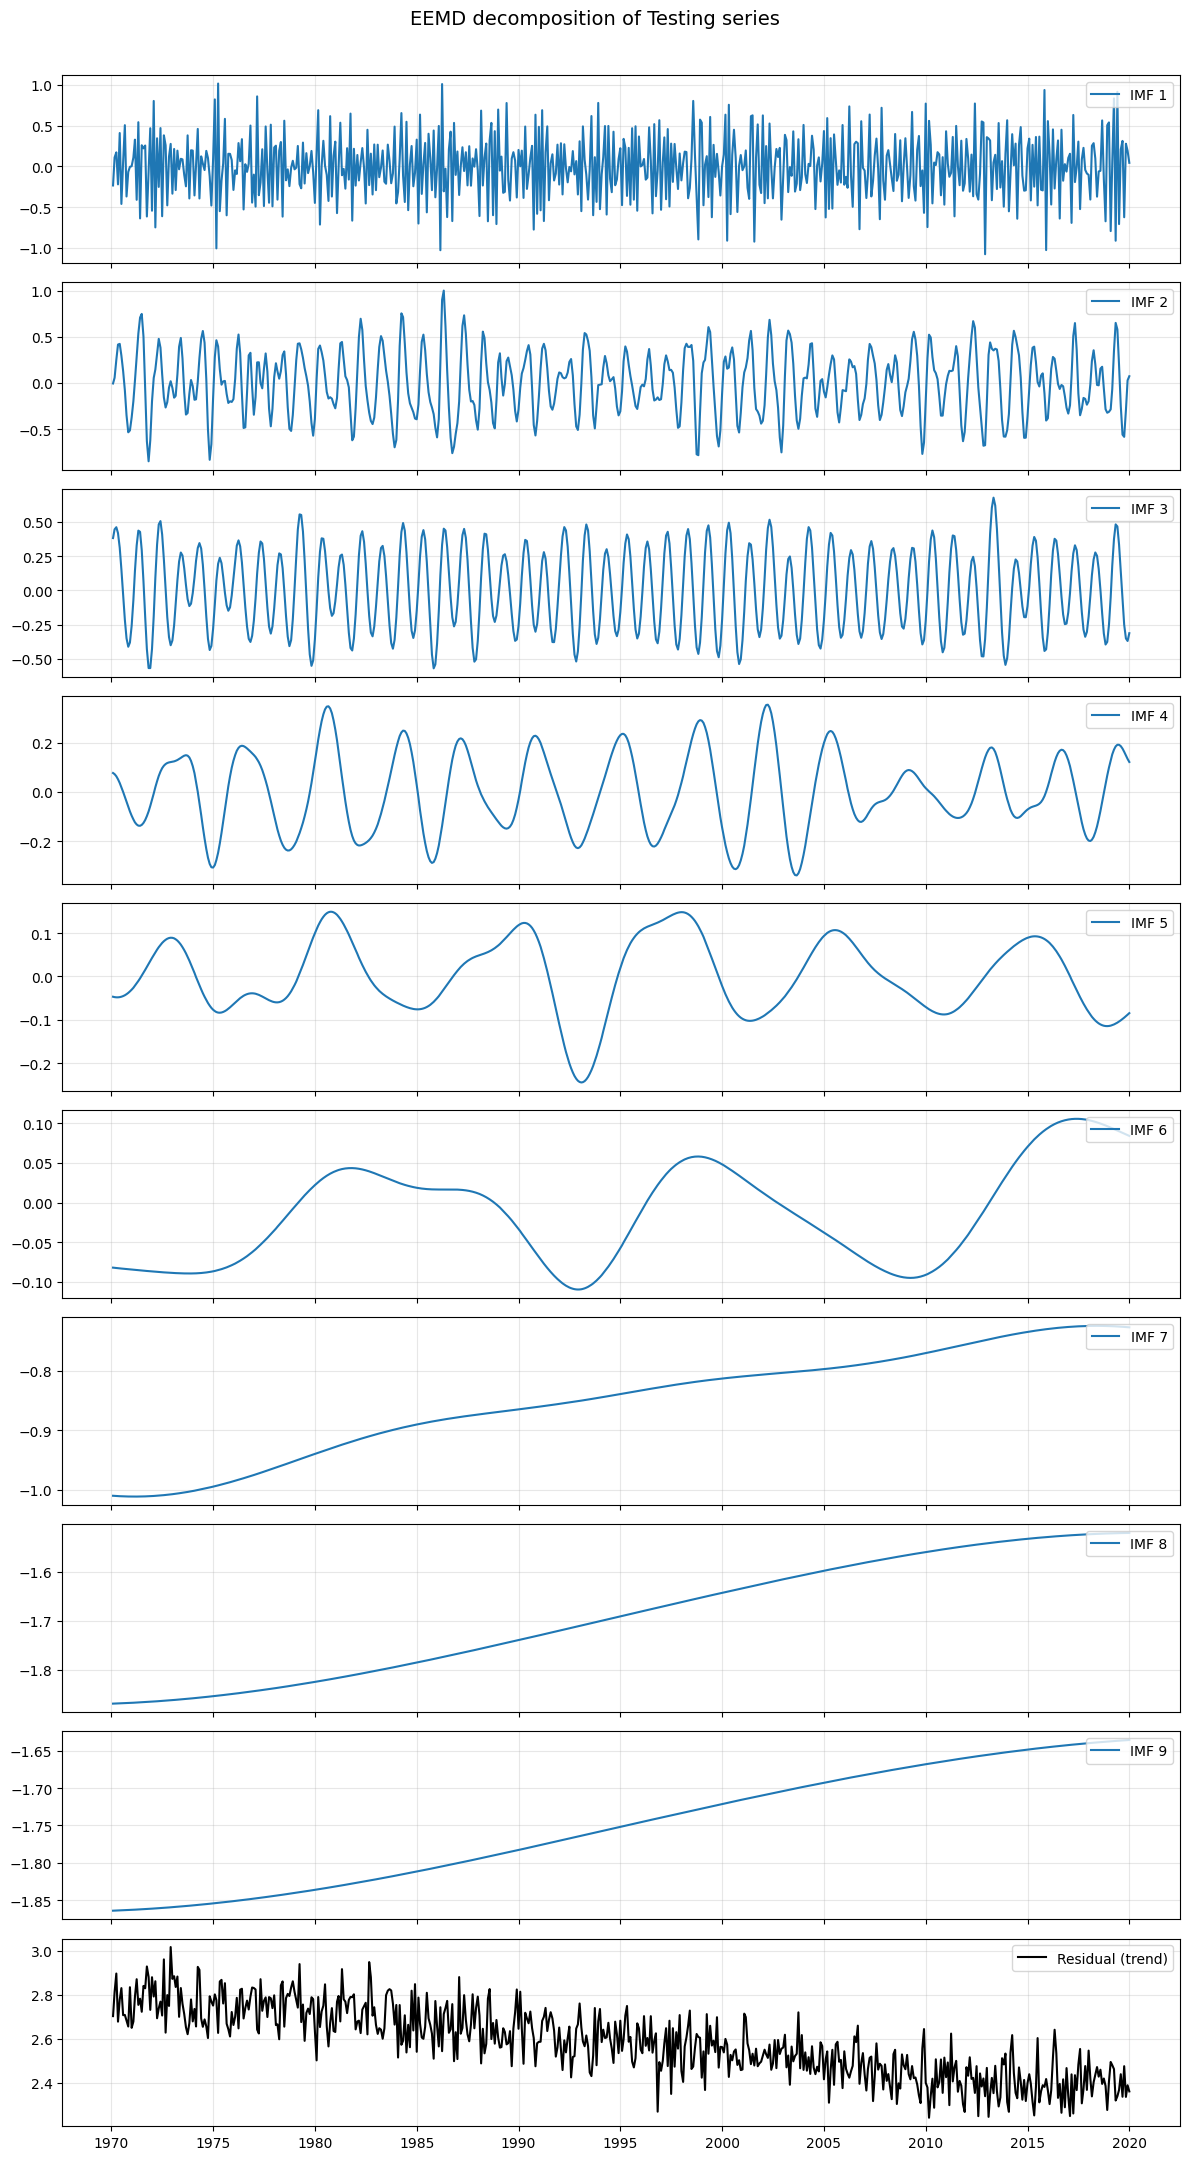

In [49]:
test_series, IMF_test, resid_test = plot_eemd_decomposition_series(df['y'], label="Testing")

In [50]:
fft_testing = imf_fft_peak_periods(IMF_test, dt=1.0, units="months")
print(fft_testing)

   IMF  peak_freq  peak_period_months
0    1   0.366667            2.727273
1    2   0.083333           12.000000
2    3   0.083333           12.000000
3    4   0.023333           42.857143
4    5   0.010000          100.000000
5    6   0.005000          200.000000
6    7   0.001667          600.000000
7    8   0.001667          600.000000
8    9   0.001667          600.000000


In [51]:
long_indices_test, long_component_test = extract_long_term_trend_from_eemd(
    imfs=IMF_test,
    resid=resid_test,
    fft_stats=fft_testing,
    add_resid=True,
    period_fraction=1/2
)

print("Long-term IMFs (1-based indices):", long_indices_test)

Long-term IMFs (1-based indices): [7, 8, 9]


In [52]:
test_smooth = lowess(long_component_test, np.arange(IMF_test.shape[1]), frac=0.1, return_sorted=False)

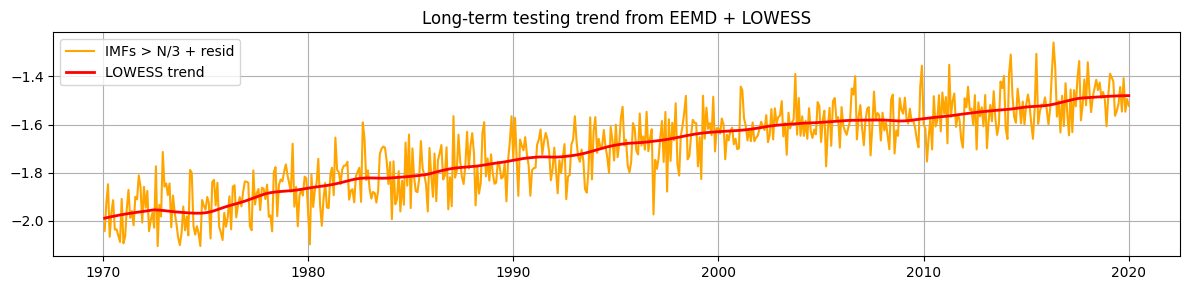

In [53]:
plt.figure(figsize=(12, 3))
plt.plot(df.index, long_component_test, label="IMFs > N/3 + resid", color="orange")
plt.plot(df.index, test_smooth, label="LOWESS trend", color="red", linewidth=2)
plt.title("Long-term testing trend from EEMD + LOWESS")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [55]:
# ------------------------------------------------------------------
# 1. Helpers to ingest local Taiwan‑CWA buoy files
# ------------------------------------------------------------------
CWA_SITES = {
    "Longdong": (25.0969, 121.9222),
    # "Hualien":  (24.0311, 121.6325),
    # "Hsinchu":  (24.7625, 120.8422),
    # "LiuqiuIsland": (22.3131, 120.3639),
}

VARIABLE_META = {
    "Hs": {
        "cwa_col": "示性波高",
        "label": "Significant wave height",
        "unit": "m"
    },
    "Wind": {
        "cwa_col": "風速",
        "label": "Wind speed",
        "unit": "m/s"
    },
    "SST": {
        "cwa_col": "海面溫度",
        "label": "Sea surface temperature",
        "unit": "°C"
    },
    # Add more if needed
}


In [ ]:
'''
from pathlib import Path
from typing import Literal, List
import pandas as pd
import warnings

CWA_ROOT = Path("../data")  # edit to actual root if needed
CWA_TIME_COL = "時間" 

def read_cwa_site(site: str, years: range | List[int] = range(2010, 2025)) -> pd.DataFrame:
    frames: List[pd.DataFrame] = []
    site_dir = CWA_ROOT / site

    for y in years:
        f = site_dir / f"{y}.csv"
        if not f.exists():
            warnings.warn(f"missing file {f}")
            continue
        df = pd.read_csv(f, skiprows=[1, 2], low_memory=False)
        df = df.rename(columns={CWA_TIME_COL: "time"})

        # Standardize names
        for std_name, meta in VARIABLE_META.items():
            if meta["cwa_col"] in df.columns:
                df = df.rename(columns={meta["cwa_col"]: std_name})

        df["time"] = pd.to_datetime(df["time"], errors="coerce")
        df = df.dropna(subset=["time"]).set_index("time")
        df["site"] = site
        frames.append(df)

    if not frames:
        raise FileNotFoundError(f"No CSV files found for {site}")
    return pd.concat(frames).sort_index()
'''    

In [ ]:
'''
cwa_sites = [read_cwa_site(site) for site in CWA_SITES]
cwa_sites_df = pd.concat(cwa_sites).sort_index()
print(cwa_sites_df.head())
'''

                                     測站編號  陣風_風速  Wind     風向      氣壓    氣溫  \
time                                                                          
2010-01-01 00:00:00  Vector_CWB_FB_46694A    6.6   4.6   65.0  1021.9  14.9   
2010-01-01 00:00:00  Vector_CWB_FB_46714D    6.7   4.8    3.0  1019.3  18.8   
2010-01-01 00:00:00  Vector_CWB_FB_46757B   11.2   8.7   32.0  1021.2  13.5   
2010-01-01 00:00:00  Vector_CWB_FB_46699A    5.2   3.0  296.0  1022.5  16.7   
2010-01-01 01:00:00  Vector_CWB_FB_46694A    6.4   4.3   69.0  1021.8  15.0   

                      SST    Hs  平均週期     波向  波浪尖峰週期  流速  分層流速{深度:流速}  流向  \
time                                                                        
2010-01-01 00:00:00  18.1  1.50   6.3   56.0     8.7 NaN          NaN NaN   
2010-01-01 00:00:00  25.3  0.44   4.4  292.0     8.0 NaN          NaN NaN   
2010-01-01 00:00:00  18.0  1.31   5.1    NaN     7.4 NaN          NaN NaN   
2010-01-01 00:00:00  22.3  1.20   5.4   56.0     8.7 NaN     

In [56]:
'''
print(len(cwa_sites_df))
cwa_sites_df.to_csv("./data/buoy/cwa_buoy_Longdong_2010-2024.csv", index=True)
'''

cwa_sites_df = pd.read_csv("./data/buoy/cwa_buoy_Longdong_2010-2024.csv", index_col=0, parse_dates=True)

In [57]:
def plot_monthly_data(master: pd.DataFrame, var: str = "Wind"):
    """
    Plot monthly-mean time series of a given variable across all sites.
    Args:
        master: pd.DataFrame with columns including 'site' and the given var
        var: standard variable name (must be in VARIABLE_META)
    """
    if var not in VARIABLE_META:
        raise ValueError(f"Unsupported variable '{var}'. Available: {list(VARIABLE_META)}")

    meta = VARIABLE_META[var]

    fig, ax = plt.subplots(figsize=(12, 4))
    for site, grp in master.groupby("site"):
        if var not in grp.columns:
            continue  # Skip site if this variable doesn't exist
        monthly = grp[var].resample("ME").mean()
        ax.plot(monthly.index, monthly, label=site)

    ax.set_ylabel(f"{meta['label']} ({meta['unit']})")
    ax.set_title(f"Monthly-mean {meta['label']}s (2010–2024)")
    ax.legend()
    ax.grid(True, alpha=.3)
    fig.autofmt_xdate()

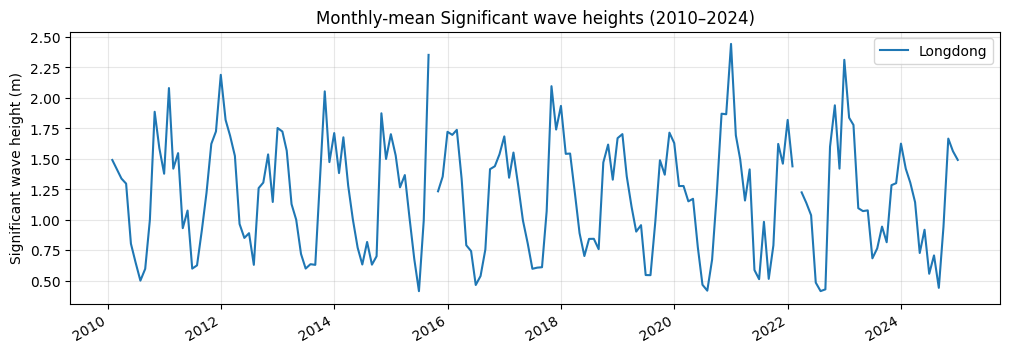

In [58]:
plot_monthly_data(cwa_sites_df, "Hs")

In [59]:
# Build daily series for a specific site and variable
def build_daily_series(master, site, var="Hs"):
    s = master.loc[master["site"] == site, var]
    daily = s.resample("D").mean()
    daily = daily.interpolate("time", limit=2).dropna()
    return daily

def plot_seasonal_trend(master: pd.DataFrame, site: str, var: str = "Hs"):
    daily = build_daily_series(master, site, var)
    
    # Seasonal decomposition
    stl = STL(daily, period=365, robust=True).fit()
    meta = VARIABLE_META[var]
    fig = stl.plot()
    fig.set_size_inches(12, 8)
    fig.suptitle(f"Seasonal Decomposition of {meta['label']} for {site} ({meta['unit']})", y=0.95)
    plt.suptitle(f"Seasonal and Trend Analysis for {site} ({var})", y=0.95)
    plt.tight_layout()
    plt.show()    

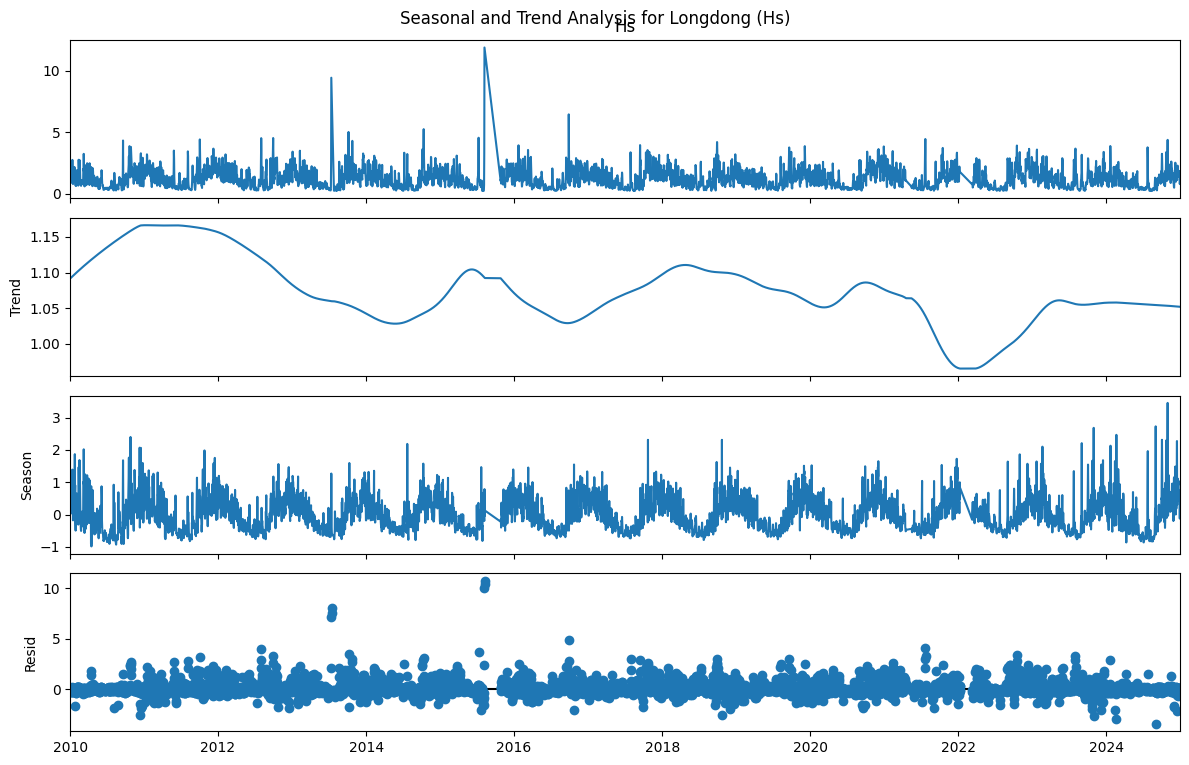

In [60]:
plot_seasonal_trend(cwa_sites_df, 'Longdong', "Hs")

In [34]:
Ld_hs = cwa_sites_df.loc[cwa_sites_df["site"] == "Longdong", "Hs"]
hs_roll = Ld_hs.rolling("72h").mean()
hs_daily = hs_roll.resample("D").mean()
hs_daily = hs_daily.interpolate("time", limit=2).dropna()

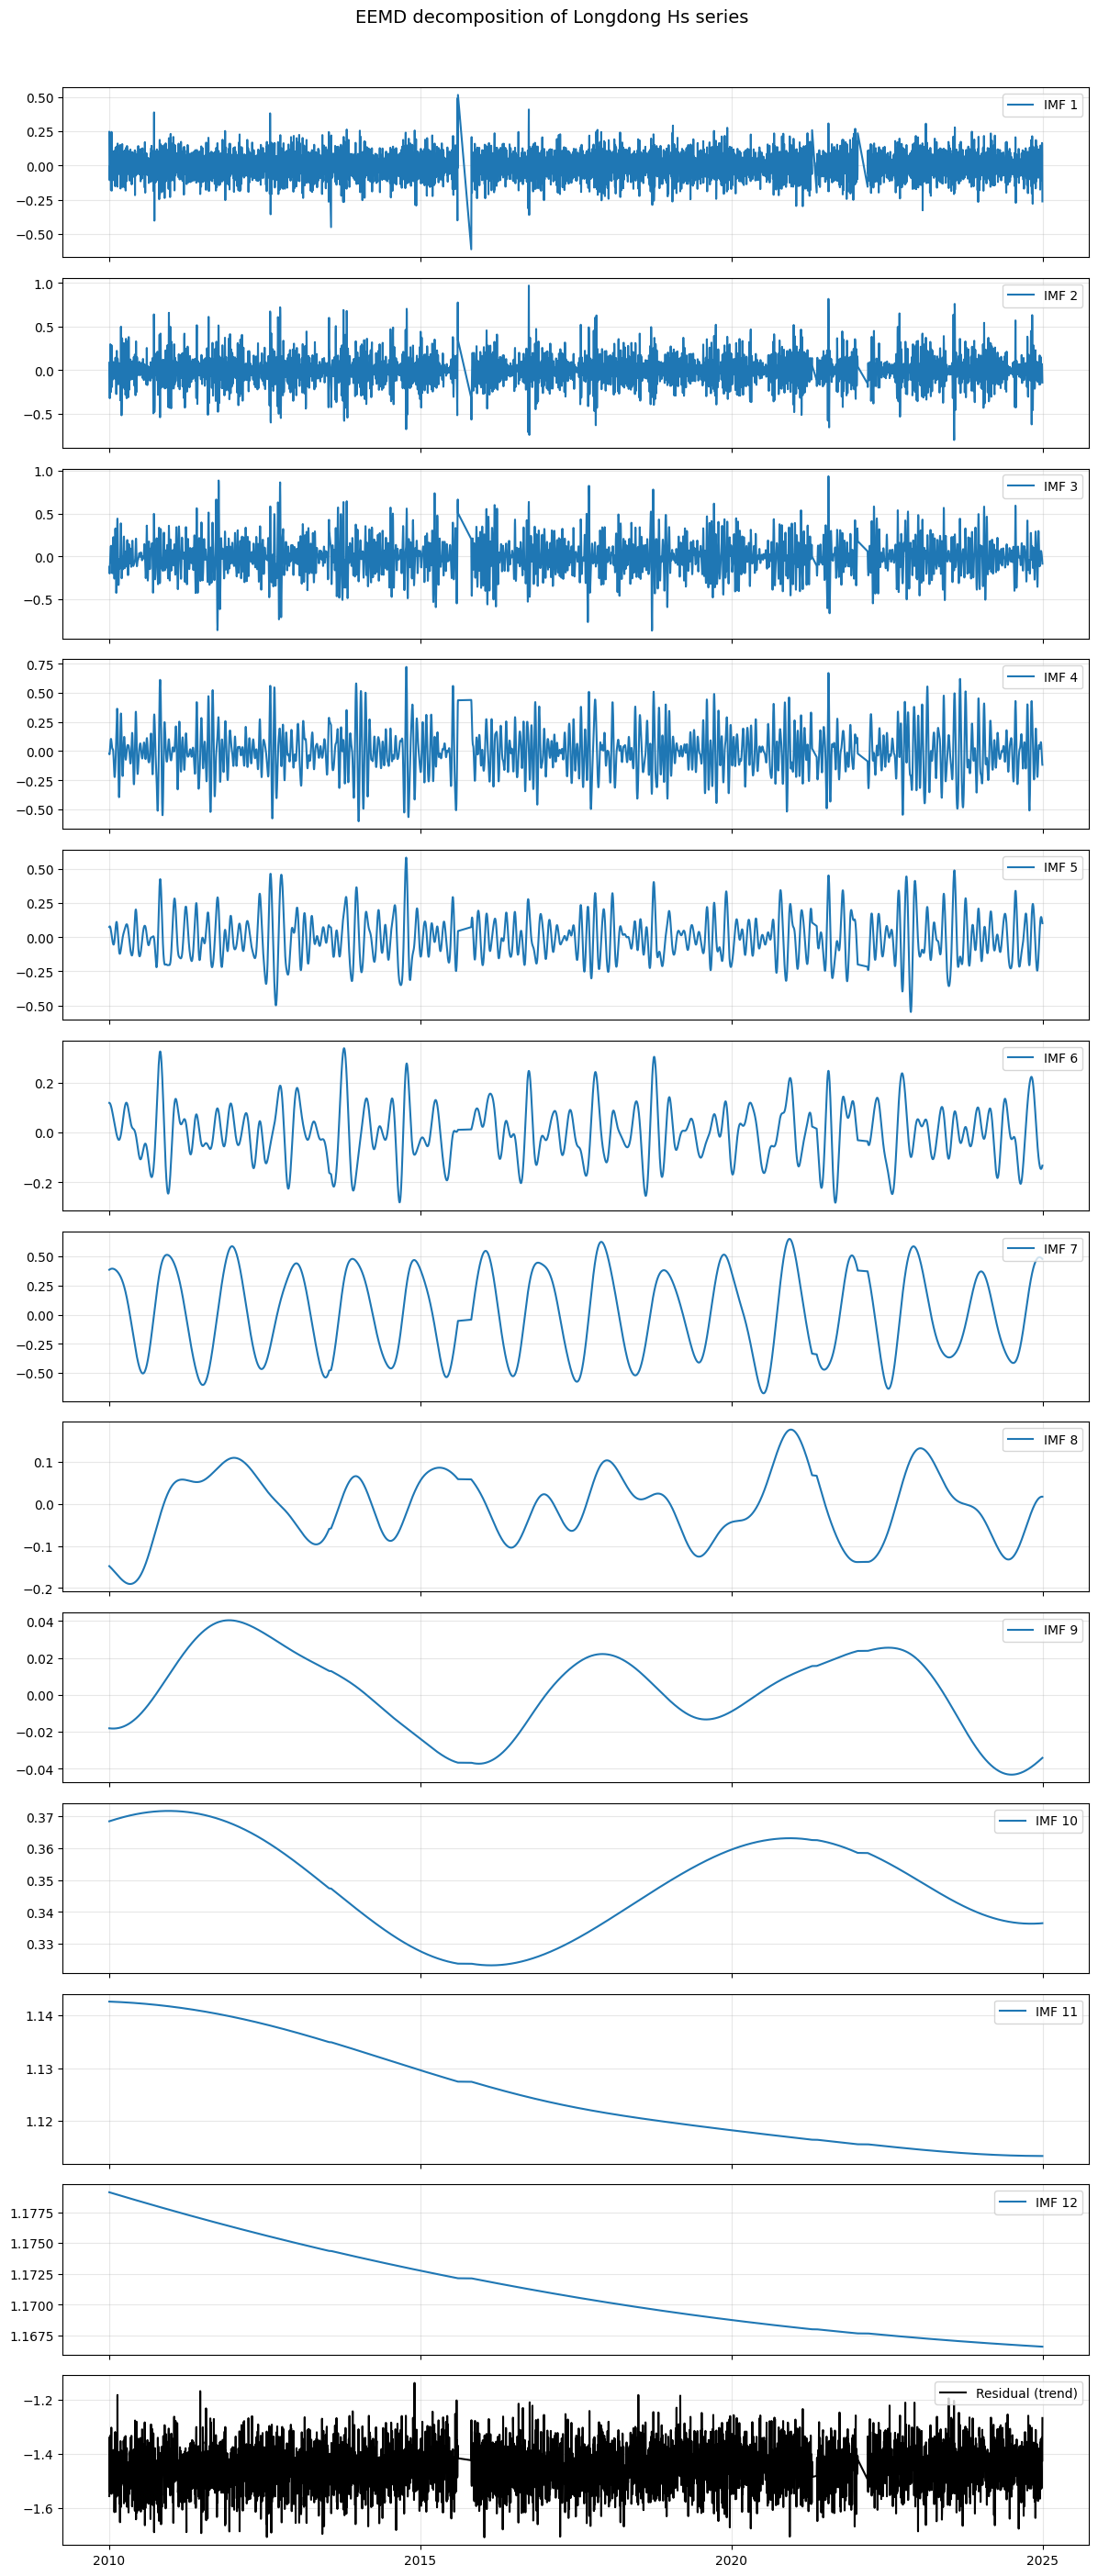

In [35]:
daily_Ld, IMF_Ld, res_Ld = plot_eemd_decomposition_series(hs_daily, 'Longdong Hs')

In [36]:
fft_stats_Ld = imf_fft_peak_periods(IMF_Ld, dt=1.0, to_months=True)
print(fft_stats_Ld)

    IMF  peak_freq  peak_period_days  peak_period_months
0     1   0.193445          5.169426            0.172314
1     2   0.136372          7.332873            0.244429
2     3   0.057826         17.293160            0.576439
3     4   0.032775         30.511494            1.017050
4     5   0.013750         72.726027            2.424201
5     6   0.008099        123.465116            4.115504
6     7   0.002825        353.933333           11.797778
7     8   0.000942       1061.800000           35.393333
8     9   0.000565       1769.666667           58.988889
9    10   0.000377       2654.500000           88.483333
10   11   0.000188       5309.000000          176.966667
11   12   0.000188       5309.000000          176.966667


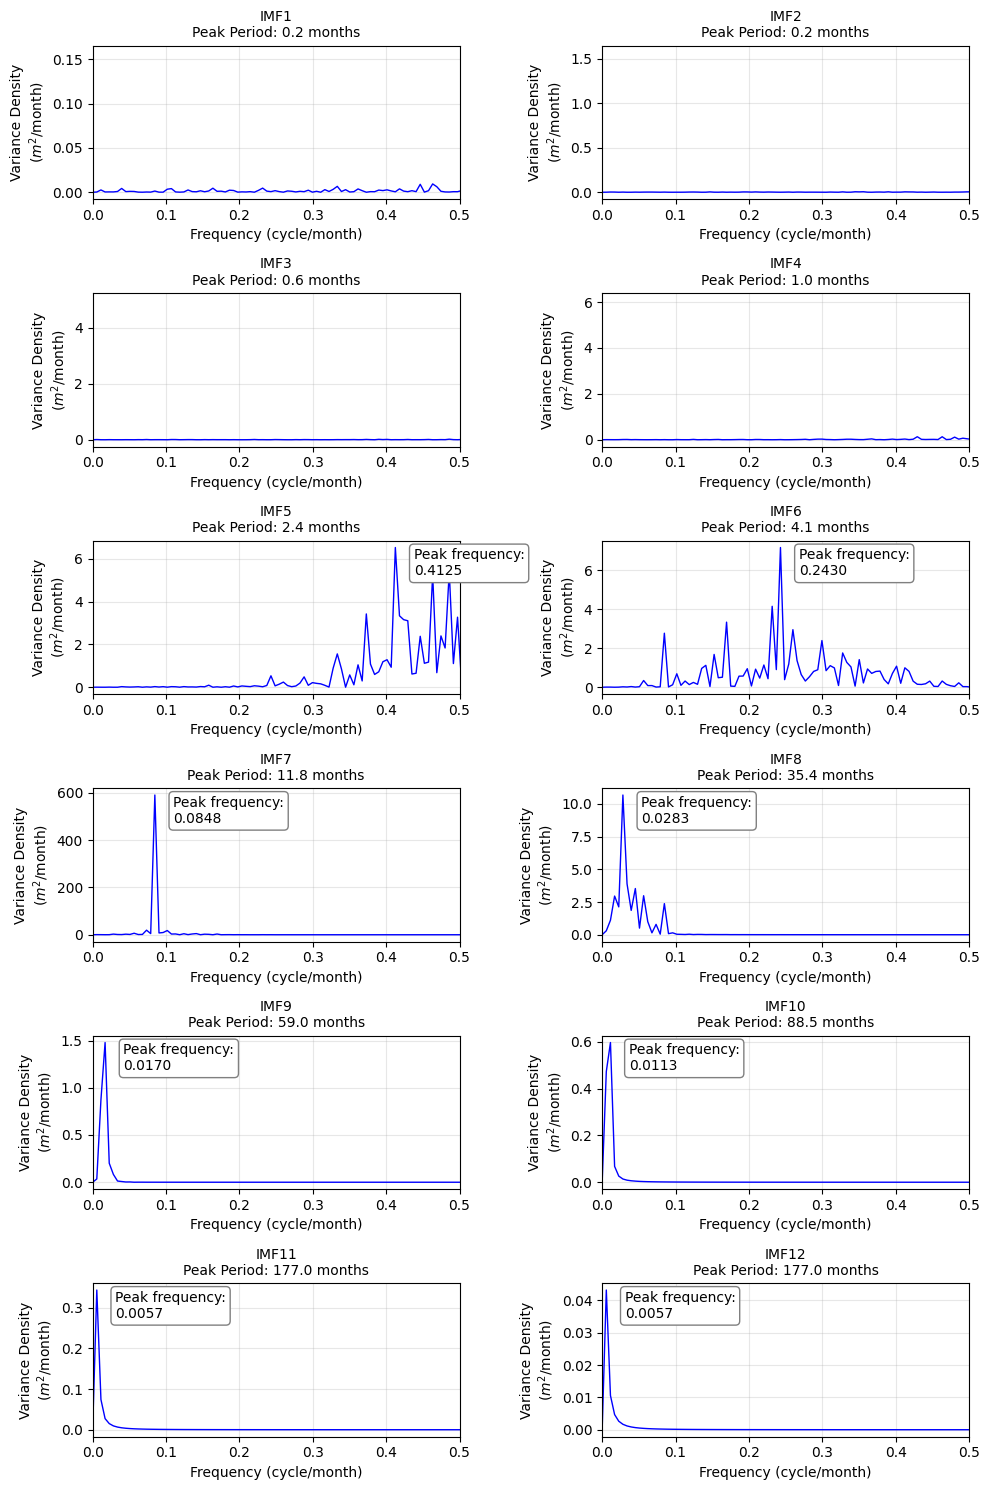

In [37]:
plot_imf_periodograms(IMF_Ld, to_months=True)

In [38]:
long_indices_Ld, long_component_Ld = extract_long_term_trend_from_eemd(
    imfs=IMF_Ld,
    resid=res_Ld,
    fft_stats=fft_stats_Ld,
    add_resid=True,
    period_fraction=1/3,
    period_var='peak_period_days'
)
print("Long-term IMFs (1-based indices):", long_indices_Ld, " Total period: ", IMF_Ld.shape[1])    


Long-term IMFs (1-based indices): [10, 11, 12]  Total period:  5309


In [39]:
Ld_smooth = lowess(long_component_Ld, np.arange(IMF_Ld.shape[1]), frac=0.4, return_sorted=False)

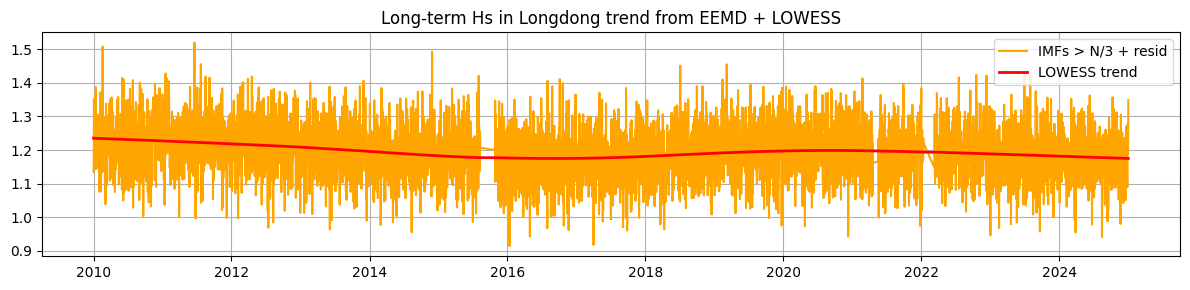

In [40]:
plt.figure(figsize=(12, 3))
plt.plot(hs_daily.index, long_component_Ld, label="IMFs > N/3 + resid", color="orange")
plt.plot(hs_daily.index, Ld_smooth, label="LOWESS trend", color="red", linewidth=2)
plt.title("Long-term Hs in Longdong trend from EEMD + LOWESS")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
def detect_extreme_events(master_df: pd.DataFrame,
                          site: str,
                          var: str = "Hs",
                          threshold: float = 6.0,
                          min_duration_hrs: int = 5) -> pd.DataFrame:
    """
    Detect extreme-wave events for a given site:
      - var > threshold
      - duration at least min_duration_hrs (hours)
    Returns a DataFrame of events with columns:
      [start, end, duration_hours, season]
    """
    # Filter site series
    s = master_df.loc[master_df["site"] == site, var]
    is_ext = s > threshold
    
    # Identify contiguous runs via group id
    grp = (is_ext != is_ext.shift()).cumsum()
    df = pd.DataFrame({"is_ext": is_ext, "grp": grp})
    
    events = []
    for gid, chunk in df.groupby("grp"):
        if not chunk["is_ext"].iloc[0]:
            continue
        # duration in hours = number of rows (hourly data)
        duration_hrs = len(chunk)
        if duration_hrs < min_duration_hrs:
            continue
        start = chunk.index[0]
        end   = chunk.index[-1]
        # classify season by start month
        m = start.month
        if m in (10,11,12,1,2,3,4):
            season = "Northeast monsoon"
        elif m in (5,6,7,8,9):
            season = "Southwest monsoon"
        else:
            season = "other"
        events.append({
            "start": start, "end": end,
            "duration_hrs": duration_hrs,
            "season": season,
            "year": start.year
        })
    return pd.DataFrame(events)


In [43]:
hs_events = detect_extreme_events(cwa_sites_df, "Longdong", threshold=4.0, min_duration_hrs=4)
print(len(hs_events), hs_events.head())

50                 start                 end  duration_hrs             season  \
0 2010-09-19 02:00:00 2010-09-19 11:00:00            10  Southwest monsoon   
1 2010-10-22 01:00:00 2010-10-22 07:00:00             7  Northeast monsoon   
2 2010-10-26 18:00:00 2010-10-26 22:00:00             5  Northeast monsoon   
3 2010-10-28 16:00:00 2010-10-28 21:00:00             6  Northeast monsoon   
4 2010-12-16 03:00:00 2010-12-16 06:00:00             4  Northeast monsoon   

   year  
0  2010  
1  2010  
2  2010  
3  2010  
4  2010  


In [44]:
def plot_extreme_event_counts(events_df: pd.DataFrame,
                              year_min: int = None,
                              year_max: int = None,
                              ax: plt.Axes = None):
    """
    Plot number of extreme events per year by season (red=summer, blue=winter).
    """
    df = events_df.copy()
    if year_min is not None:
        df = df[df["year"] >= year_min]
    if year_max is not None:
        df = df[df["year"] <= year_max]

    counts = df.groupby(["year", "season"]).size().unstack(fill_value=0)

    years = np.arange(counts.index.min(), counts.index.max() + 1)
    winter = counts.get("Northeast monsoon", pd.Series(0, index=counts.index)).reindex(years, fill_value=0)
    summer = counts.get("Southwest monsoon", pd.Series(0, index=counts.index)).reindex(years, fill_value=0)

    if ax is None:
        fig, ax = plt.subplots(figsize=(12,4))
    ax.bar(years, winter, color="#619cff", alpha=0.7, label="Northeast monsoon")
    ax.bar(years, summer, color="#f8766d", alpha=0.7, label="Southwest monsoon")
    ax.set_xlim(years.min()-0.5, years.max()+0.5)
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of Extreme Events")
    ax.legend()
    ax.grid(alpha=0.3)
    return ax

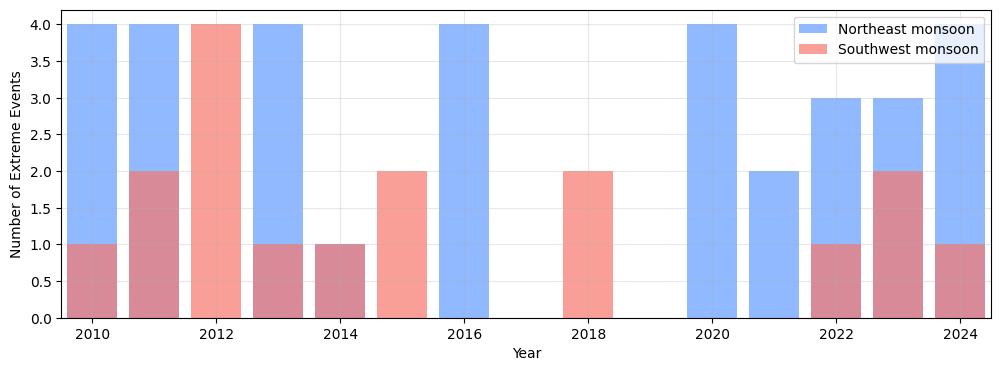

In [95]:
ax = plot_extreme_event_counts(hs_events)

In [ ]:
# Download Historical typhoon data from IBTrACS WP: West Pacific dataset from https://www.ncei.noaa.gov/products/international-best-track-archive
'''
csv_path = "d:/backup/data/ibtracs.WP.list.v04r01.csv"
cols = ['SID', 'NAME', 'ISO_TIME', 'LAT', 'LON', 'USA_WIND']
bt = pd.read_csv(csv_path, usecols=cols, low_memory=False)

# Parse time and filter by years 2010–2025
bt['ISO_TIME'] = pd.to_datetime(bt['ISO_TIME'], format="%Y-%m-%d %H:%M:%S", errors='coerce')
bt = bt[(bt['ISO_TIME'].dt.year >= 2010) & (bt['ISO_TIME'].dt.year <= 2025)]
bt['LAT'] = pd.to_numeric(bt['LAT'], errors='coerce')
bt['LON'] = pd.to_numeric(bt['LON'], errors='coerce')
bt = bt.dropna(subset=['LAT', 'LON'])
print(f"Loaded {len(bt)}, and data: ", bt.head())
'''

'''
# Retry with manual haversine implementation since `haversine` package is unavailable
# Haversine formula to calculate distance between two lat/lon points
def haversine_manual(coord1, coord2):
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    R = 6371  # Earth radius in km

    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)

    a = np.sin(dphi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2) ** 2
    return 2 * R * np.arcsin(np.sqrt(a))
'''


Loaded 29268, and data:                    SID     NAME            ISO_TIME  LAT    LON USA_WIND
215961  2010018N07113  UNNAMED 2010-01-18 00:00:00  6.9  113.2       15
215962  2010018N07113  UNNAMED 2010-01-18 03:00:00  7.0  113.1       18
215963  2010018N07113  UNNAMED 2010-01-18 06:00:00  7.1  113.0       20
215964  2010018N07113  UNNAMED 2010-01-18 09:00:00  7.3  112.9       23
215965  2010018N07113  UNNAMED 2010-01-18 12:00:00  7.5  112.7       25


In [55]:
'''
station = CWA_SITES["Hualien"] #(24.0311, 121.6325)
#　print(f"Calculating distances to {station}...")
bt['dist_km'] = bt.apply(lambda row: haversine_manual(station, (row['LAT'], row['LON'])), axis=1)
print(bt.head())
bt.to_csv('../data/examples/typhoon_events_2010-202506.csv', index=False)
'''
# Load the typhoon data
bt = pd.read_csv('../data/examples/typhoon_events_2010-202506.csv')
print(bt.head)

<bound method NDFrame.head of                  SID     NAME             ISO_TIME   LAT    LON USA_WIND  \
0      2010018N07113  UNNAMED  2010-01-18 00:00:00   6.9  113.2       15   
1      2010018N07113  UNNAMED  2010-01-18 03:00:00   7.0  113.1       18   
2      2010018N07113  UNNAMED  2010-01-18 06:00:00   7.1  113.0       20   
3      2010018N07113  UNNAMED  2010-01-18 09:00:00   7.3  112.9       23   
4      2010018N07113  UNNAMED  2010-01-18 12:00:00   7.5  112.7       25   
...              ...      ...                  ...   ...    ...      ...   
29263  2025174N23146    SEPAT  2025-06-23 12:00:00  27.0  143.0       39   
29264  2025174N23146    SEPAT  2025-06-23 15:00:00  27.7  142.5       37   
29265  2025174N23146    SEPAT  2025-06-23 18:00:00  28.4  141.9       35   
29266  2025174N23146    SEPAT  2025-06-23 21:00:00  28.9  141.4       35   
29267  2025174N23146    SEPAT  2025-06-24 00:00:00  29.3  141.0       35   

           dist_km  
0      2106.579043  
1      2101.050

In [56]:
'''
station = CWA_SITES["Hualien"] #(24.0311, 121.6325)
#　print(f"Calculating distances to {station}...")
bt['dist_km'] = bt.apply(lambda row: haversine_manual(station, (row['LAT'], row['LON'])), axis=1)
print(bt.head())
bt.to_csv('../data/examples/typhoon_events_2010-202506.csv')
'''
# Load the typhoon data
bt = pd.read_csv('../data/examples/typhoon_events_2010-202506.csv')
print(bt.head())

             SID     NAME             ISO_TIME  LAT    LON USA_WIND  \
0  2010018N07113  UNNAMED  2010-01-18 00:00:00  6.9  113.2       15   
1  2010018N07113  UNNAMED  2010-01-18 03:00:00  7.0  113.1       18   
2  2010018N07113  UNNAMED  2010-01-18 06:00:00  7.1  113.0       20   
3  2010018N07113  UNNAMED  2010-01-18 09:00:00  7.3  112.9       23   
4  2010018N07113  UNNAMED  2010-01-18 12:00:00  7.5  112.7       25   

       dist_km  
0  2106.579043  
1  2101.050930  
2  2095.617487  
3  2080.247305  
4  2069.923997  


In [57]:
# Filter those within 300 km
bt_near = bt[bt['dist_km'] < 300].copy()
print(f"Loaded {len(bt_near)}, and data: ", bt_near.head())

Loaded 538, and data:                 SID      NAME             ISO_TIME   LAT    LON USA_WIND  \
346  2010239N15118  LIONROCK  2010-09-01 00:00:00  22.3  119.5       50   
347  2010239N15118  LIONROCK  2010-09-01 03:00:00  22.6  119.4       53   
348  2010239N15118  LIONROCK  2010-09-01 06:00:00  22.8  119.2       55   
349  2010239N15118  LIONROCK  2010-09-01 09:00:00  23.0  119.0       55   
350  2010239N15118  LIONROCK  2010-09-01 12:00:00  23.2  118.9       55   

        dist_km  
346  290.812138  
347  278.007554  
348  283.444538  
349  291.863980  
350  293.324921  


In [59]:
# Get the closest point per storm
closest = bt_near.loc[bt_near.groupby("SID")["dist_km"].idxmin()].copy()
closest = closest[['SID', 'NAME', 'ISO_TIME', 'LAT', 'LON', 'dist_km', 'USA_WIND']]
closest = closest.rename(columns={'ISO_TIME': 'closest_date'})
closest['closest_date'] = pd.to_datetime(closest['closest_date'])

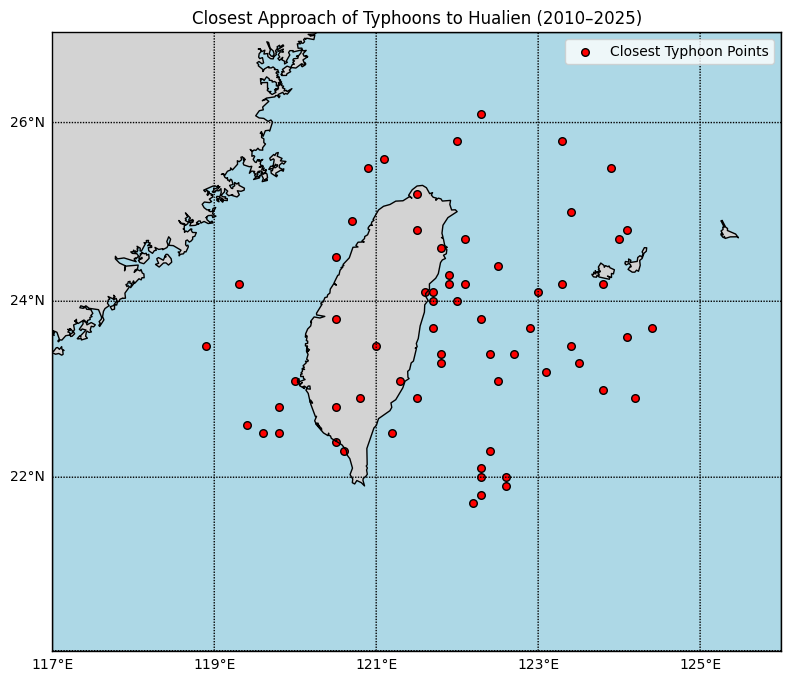

In [ ]:
'''
fig, ax = plt.subplots(figsize=(8, 8))
m = Basemap(projection='merc',
            llcrnrlon=117, llcrnrlat=20,
            urcrnrlon=126, urcrnrlat=27,
            resolution='i', ax=ax)

m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='lightblue')
m.fillcontinents(color='lightgray', lake_color='lightblue')
m.drawparallels(np.arange(20, 28, 2), labels=[1,0,0,0])
m.drawmeridians(np.arange(117, 127, 2), labels=[0,0,0,1])

# Storm closest points
x, y = m(closest['LON'].values, closest['LAT'].values)
m.scatter(x, y, c='red', s=30, edgecolors='k', label='Closest Typhoon Points')

plt.title("Closest Approach of Typhoons to Hualien (2010–2025)")
plt.legend()
plt.tight_layout()
plt.show()
'''

In [61]:
def plot_hs_events_overlay(
    events: pd.DataFrame,
    overlay: pd.Series,
    overlay_label: str = "Example series",
    typhoon_df: pd.DataFrame | None = None,
    wind_scale: float = 20.0
):
    """
    Plot monthly extreme wave event counts (summer/winter) as side-by-side bars,
    overlaid with time-series (ONI for example), and typhoon occurrence segments.

    Parameters:
    -----------
    events : DataFrame
        Must contain:
          - 'start'   : datetime of event onset
          - 'season'  : 'summer' or 'winter'
    overlay : Series
        Time-series overlay (DatetimeIndex).
    typhoon_df : DataFrame, optional
        Must contain:
          - 'closest_date' : datetime of closest approach
          - 'USA_WIND'     : wind speed (string or numeric)
    wind_scale : float
        Divisor to scale USA_WIND into bar-chart height units.
    """
    # 1) Prepare events
    ev = events[events['season'].isin(['Southwest monsoon','Northeast monsoon'])].copy()
    ev['month'] = ev['start'].dt.to_period('M').dt.to_timestamp()
    monthly = ev.groupby(['month','season']).size().unstack(fill_value=0)
    for c in ('Southwest monsoon','Northeast monsoon'):
        if c not in monthly.columns:
            monthly[c] = 0
    monthly = monthly.sort_index()

    # 2) Bar positions
    months = monthly.index.to_pydatetime()
    x = mdates.date2num(months)
    total_w = 20
    sw = total_w/2
    sx, wx = x - sw/2, x + sw/2

    # 3) Plot bars
    fig, ax = plt.subplots(figsize=(12,4))

    # 4) Overlay time-series
    ax.spines['right'].set_position(('outward', 60))
    ax.plot(overlay.index, overlay.values, color='orange', lw=1.5, label=overlay_label)
    ax.set_ylabel(overlay_label, color='orange')
    ax.tick_params(axis='y', labelcolor='orange')
    ax.axhline(y=0.5, linestyle="dotted", linewidth=0.5, color="red", label="El Niño")
    ax.axhline(y=-0.5, linestyle="dotted", linewidth=0.5, color="blue", label="La Niña")

    ax1 = ax.twinx()
    # 6) Overlay typhoon segments
    if typhoon_df is not None and not typhoon_df.empty:
        ty = typhoon_df.copy()
        ty['wind'] = pd.to_numeric(ty['USA_WIND'], errors='coerce')
        ty = ty.dropna(subset=['closest_date', 'wind'])
        ty['closest_date'] = pd.to_datetime(ty['closest_date'])
        ty['h'] = ty['wind'] / wind_scale

        for _, r in ty.iterrows():
            if monthly.index.min() <= r['closest_date'] <= monthly.index.max():
                ax1.vlines(r['closest_date'], 0, r['h'],
                           color='gray', lw=2, alpha=.6)

    ax1.bar(sx, monthly['Southwest monsoon'], width=sw, label='Southwest monsoon', color='#f8766d', alpha=0.7)
    ax1.bar(wx, monthly['Northeast monsoon'], width=sw, label='Northeast monsoon', color='#619cff', alpha=0.7)
    ax1.set_ylabel('Extreme events')
    ax1.set_xlim(x.min()-30, x.max()+30)
    ax1.xaxis.set_major_locator(mdates.YearLocator())
    ax1.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

    # 7) Legend
    lines, labs = [], []
    for a in (ax, ax1):
        l, label = a.get_legend_handles_labels()
        lines += l; labs += label
    ax1.legend(lines, labs, loc='upper left')

    plt.title(f"Monthly extreme wave events vs {overlay_label}\n(with Typhoon indicators)")
    fig.tight_layout()
    plt.show()


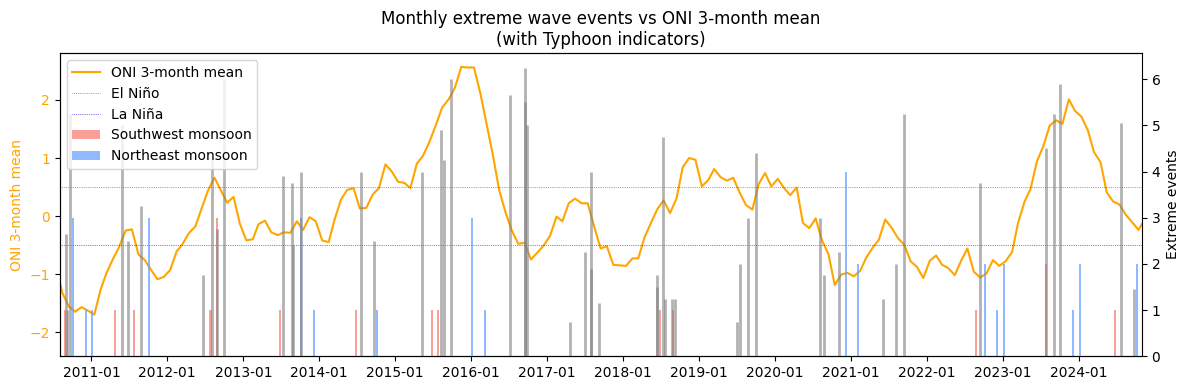

In [62]:
plot_hs_events_overlay(
    events=hs_events,
    overlay=ssta,
    overlay_label="ONI 3-month mean",
    typhoon_df=closest[['closest_date','USA_WIND']],
    wind_scale=20.0
)